# CONVULATION AUTOENCODERS FOR CT DIACOM IMAGES

In [1]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
#loading images
path="D:/Sahana/New_Segment"

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_batches=ImageDataGenerator().flow_from_directory(path,target_size=(224,224),classes=['autoencoders_input'],batch_size=11)
imgs,labels=next(train_batches)

Found 2 images belonging to 1 classes.


In [9]:
IMG_SHAPE=imgs.shape[1:] 

In [10]:
imgs = imgs.astype('float32') / 255.0 - 0.5

In [11]:
print("img.max:",imgs.max())
print("img.min:",imgs.min())

img.max: 0.49607843
img.min: -0.5


In [12]:
x_train=imgs

In [13]:
len(x_train)

2

In [14]:
x_train.shape

(2, 224, 224, 3)

In [15]:
IMG_SHAPE

(224, 224, 3)

In [16]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

The images given as input to autoencoders.
images shape: (2, 224, 224, 3)
attr shape: (2, 1)


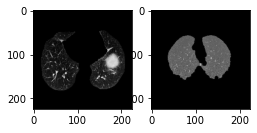

In [18]:
plt.title('sample images')

for i in range(2):
    plt.subplot(2,3,i+1)
    show_image(imgs[i])
    

print("The images given as input to autoencoders.")
print("images shape:", imgs.shape)
print("attr shape:", labels.shape)

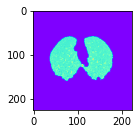

In [32]:
plt.subplot(221)
#CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r,plasma_r', 'prism',
#'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r'
plt.imshow(x_train[1][:,:,2],cmap="rainbow")

In [33]:
def build_deep_autoencoder(img_shape, code_size):
    
    H,W,C = img_shape
    
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    
    encoder.add(L.Conv2D(filters=32,input_shape=(224,224,3), kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    
    decoder.add(L.Dense(14*14*256,))
    decoder.add(L.Reshape((14,14, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


In [34]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    print("encoder",encoder.output_shape[1:])
    print("decoder",decoder.output_shape[1:])
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")   

Testing code size 1
encoder (1,)
decoder (224, 224, 3)
Testing code size 8
encoder (8,)
decoder (224, 224, 3)
Testing code size 32
encoder (32,)
decoder (224, 224, 3)
Testing code size 128
encoder (128,)
decoder (224, 224, 3)
Testing code size 512
encoder (512,)
decoder (224, 224, 3)
All tests passed!


In [35]:
tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=1000)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [36]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [37]:
code

<tf.Tensor 'sequential/Identity:0' shape=(None, 1000) dtype=float32>

In [38]:
inp

<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>

In [39]:
reconstruction

<tf.Tensor 'sequential_1/Identity:0' shape=(None, 224, 224, 3) dtype=float32>

In [40]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse',metrics=['accuracy'])

In [41]:
x_test=x_train[:1]

In [42]:
x_test.shape

(1, 224, 224, 3)

In [43]:
autoencoder.fit(x=x_train, y=x_train, epochs=6000,validation_data=[x_test, x_test])

Train on 2 samples, validate on 1 samples
Epoch 1/6000
2/2 [==============================] - 6s 3s/sample - loss: 0.2113 - accuracy: 0.3417 - val_loss: 0.2143 - val_accuracy: 0.2878
Epoch 2/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.2075 - accuracy: 0.2873 - val_loss: 0.2076 - val_accuracy: 0.1394
Epoch 3/6000
2/2 [==============================] - 0s 49ms/sample - loss: 0.2026 - accuracy: 0.1379 - val_loss: 0.1996 - val_accuracy: 0.2299
Epoch 4/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.1927 - accuracy: 0.2286 - val_loss: 0.1603 - val_accuracy: 0.1056
Epoch 5/6000
2/2 [==============================] - 0s 44ms/sample - loss: 0.1558 - accuracy: 0.1046 - val_loss: 0.1370 - val_accuracy: 0.1016
Epoch 6/6000
2/2 [==============================] - 0s 54ms/sample - loss: 0.1336 - accuracy: 0.1006 - val_loss: 0.1135 - val_accuracy: 0.0832
Epoch 7/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.1110 - accuracy: 0.0813 -

Epoch 58/6000
2/2 [==============================] - 0s 45ms/sample - loss: 0.0042 - accuracy: 0.3418 - val_loss: 0.0046 - val_accuracy: 0.3248
Epoch 59/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0041 - accuracy: 0.3330 - val_loss: 0.0046 - val_accuracy: 0.3214
Epoch 60/6000
2/2 [==============================] - 0s 46ms/sample - loss: 0.0041 - accuracy: 0.3296 - val_loss: 0.0045 - val_accuracy: 0.3269
Epoch 61/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0040 - accuracy: 0.3341 - val_loss: 0.0045 - val_accuracy: 0.3330
Epoch 62/6000
2/2 [==============================] - 0s 46ms/sample - loss: 0.0040 - accuracy: 0.3393 - val_loss: 0.0045 - val_accuracy: 0.3337
Epoch 63/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.0040 - accuracy: 0.3389 - val_loss: 0.0044 - val_accuracy: 0.3304
Epoch 64/6000
2/2 [==============================] - 0s 43ms/sample - loss: 0.0039 - accuracy: 0.3356 - val_loss: 0.0044 - val_accuracy:

Epoch 115/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0028 - accuracy: 0.3457 - val_loss: 0.0032 - val_accuracy: 0.3463
Epoch 116/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.0028 - accuracy: 0.3470 - val_loss: 0.0032 - val_accuracy: 0.3468
Epoch 117/6000
2/2 [==============================] - 0s 43ms/sample - loss: 0.0028 - accuracy: 0.3475 - val_loss: 0.0032 - val_accuracy: 0.3467
Epoch 118/6000
2/2 [==============================] - 0s 49ms/sample - loss: 0.0028 - accuracy: 0.3476 - val_loss: 0.0032 - val_accuracy: 0.3469
Epoch 119/6000
2/2 [==============================] - 0s 52ms/sample - loss: 0.0028 - accuracy: 0.3479 - val_loss: 0.0032 - val_accuracy: 0.3475
Epoch 120/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0027 - accuracy: 0.3485 - val_loss: 0.0032 - val_accuracy: 0.3474
Epoch 121/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0027 - accuracy: 0.3486 - val_loss: 0.0031 - val_ac

Epoch 172/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.0022 - accuracy: 0.3508 - val_loss: 0.0026 - val_accuracy: 0.3492
Epoch 173/6000
2/2 [==============================] - 0s 43ms/sample - loss: 0.0022 - accuracy: 0.3508 - val_loss: 0.0026 - val_accuracy: 0.3491
Epoch 174/6000
2/2 [==============================] - 0s 52ms/sample - loss: 0.0022 - accuracy: 0.3506 - val_loss: 0.0026 - val_accuracy: 0.3489
Epoch 175/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0022 - accuracy: 0.3504 - val_loss: 0.0026 - val_accuracy: 0.3487
Epoch 176/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.0022 - accuracy: 0.3504 - val_loss: 0.0025 - val_accuracy: 0.3488
Epoch 177/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.0022 - accuracy: 0.3504 - val_loss: 0.0025 - val_accuracy: 0.3489
Epoch 178/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0022 - accuracy: 0.3506 - val_loss: 0.0025 - val_ac

Epoch 229/6000
2/2 [==============================] - 0s 50ms/sample - loss: 0.0018 - accuracy: 0.3511 - val_loss: 0.0022 - val_accuracy: 0.3501
Epoch 230/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.0018 - accuracy: 0.3510 - val_loss: 0.0022 - val_accuracy: 0.3503
Epoch 231/6000
2/2 [==============================] - 0s 43ms/sample - loss: 0.0018 - accuracy: 0.3510 - val_loss: 0.0022 - val_accuracy: 0.3499
Epoch 232/6000
2/2 [==============================] - 0s 44ms/sample - loss: 0.0018 - accuracy: 0.3509 - val_loss: 0.0021 - val_accuracy: 0.3499
Epoch 233/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0018 - accuracy: 0.3509 - val_loss: 0.0021 - val_accuracy: 0.3501
Epoch 234/6000
2/2 [==============================] - 0s 50ms/sample - loss: 0.0018 - accuracy: 0.3510 - val_loss: 0.0021 - val_accuracy: 0.3502
Epoch 235/6000
2/2 [==============================] - 0s 43ms/sample - loss: 0.0018 - accuracy: 0.3511 - val_loss: 0.0021 - val_ac

Epoch 286/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0016 - accuracy: 0.3497 - val_loss: 0.0019 - val_accuracy: 0.3484
Epoch 287/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.0016 - accuracy: 0.3495 - val_loss: 0.0019 - val_accuracy: 0.3485
Epoch 288/6000
2/2 [==============================] - 0s 43ms/sample - loss: 0.0016 - accuracy: 0.3497 - val_loss: 0.0019 - val_accuracy: 0.3483
Epoch 289/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.0016 - accuracy: 0.3495 - val_loss: 0.0019 - val_accuracy: 0.3484
Epoch 290/6000
2/2 [==============================] - 0s 49ms/sample - loss: 0.0016 - accuracy: 0.3496 - val_loss: 0.0018 - val_accuracy: 0.3483
Epoch 291/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0015 - accuracy: 0.3495 - val_loss: 0.0018 - val_accuracy: 0.3483
Epoch 292/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0015 - accuracy: 0.3495 - val_loss: 0.0018 - val_ac

Epoch 343/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0014 - accuracy: 0.3477 - val_loss: 0.0016 - val_accuracy: 0.3465
Epoch 344/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0014 - accuracy: 0.3477 - val_loss: 0.0016 - val_accuracy: 0.3466
Epoch 345/6000
2/2 [==============================] - 0s 52ms/sample - loss: 0.0014 - accuracy: 0.3478 - val_loss: 0.0016 - val_accuracy: 0.3466
Epoch 346/6000
2/2 [==============================] - 0s 49ms/sample - loss: 0.0014 - accuracy: 0.3478 - val_loss: 0.0016 - val_accuracy: 0.3465
Epoch 347/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0014 - accuracy: 0.3477 - val_loss: 0.0016 - val_accuracy: 0.3464
Epoch 348/6000
2/2 [==============================] - 0s 44ms/sample - loss: 0.0014 - accuracy: 0.3476 - val_loss: 0.0016 - val_accuracy: 0.3465
Epoch 349/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.0014 - accuracy: 0.3476 - val_loss: 0.0016 - val_ac

Epoch 400/6000
2/2 [==============================] - 0s 45ms/sample - loss: 0.0013 - accuracy: 0.3225 - val_loss: 0.0016 - val_accuracy: 0.3391
Epoch 401/6000
2/2 [==============================] - 0s 46ms/sample - loss: 0.0013 - accuracy: 0.3385 - val_loss: 0.0016 - val_accuracy: 0.3386
Epoch 402/6000
2/2 [==============================] - 0s 46ms/sample - loss: 0.0014 - accuracy: 0.3374 - val_loss: 0.0015 - val_accuracy: 0.3224
Epoch 403/6000
2/2 [==============================] - 0s 46ms/sample - loss: 0.0013 - accuracy: 0.3220 - val_loss: 0.0016 - val_accuracy: 0.3155
Epoch 404/6000
2/2 [==============================] - 0s 44ms/sample - loss: 0.0014 - accuracy: 0.3159 - val_loss: 0.0015 - val_accuracy: 0.3292
Epoch 405/6000
2/2 [==============================] - 0s 52ms/sample - loss: 0.0013 - accuracy: 0.3295 - val_loss: 0.0015 - val_accuracy: 0.3454
Epoch 406/6000
2/2 [==============================] - 0s 45ms/sample - loss: 0.0013 - accuracy: 0.3453 - val_loss: 0.0016 - val_ac

Epoch 457/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0011 - accuracy: 0.3452 - val_loss: 0.0013 - val_accuracy: 0.3447
Epoch 458/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0011 - accuracy: 0.3441 - val_loss: 0.0013 - val_accuracy: 0.3434
Epoch 459/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0011 - accuracy: 0.3426 - val_loss: 0.0013 - val_accuracy: 0.3439
Epoch 460/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.0011 - accuracy: 0.3430 - val_loss: 0.0013 - val_accuracy: 0.3452
Epoch 461/6000
2/2 [==============================] - 0s 45ms/sample - loss: 0.0011 - accuracy: 0.3444 - val_loss: 0.0013 - val_accuracy: 0.3456
Epoch 462/6000
2/2 [==============================] - 0s 48ms/sample - loss: 0.0011 - accuracy: 0.3450 - val_loss: 0.0013 - val_accuracy: 0.3442
Epoch 463/6000
2/2 [==============================] - 0s 52ms/sample - loss: 0.0011 - accuracy: 0.3435 - val_loss: 0.0013 - val_ac

Epoch 514/6000
2/2 [==============================] - 0s 51ms/sample - loss: 0.0010 - accuracy: 0.3411 - val_loss: 0.0012 - val_accuracy: 0.3421
Epoch 515/6000
2/2 [==============================] - 0s 47ms/sample - loss: 0.0010 - accuracy: 0.3410 - val_loss: 0.0012 - val_accuracy: 0.3418
Epoch 516/6000
2/2 [==============================] - 0s 42ms/sample - loss: 0.0010 - accuracy: 0.3410 - val_loss: 0.0012 - val_accuracy: 0.3417
Epoch 517/6000
2/2 [==============================] - 0s 52ms/sample - loss: 0.0010 - accuracy: 0.3409 - val_loss: 0.0012 - val_accuracy: 0.3418
Epoch 518/6000
2/2 [==============================] - 0s 46ms/sample - loss: 0.0010 - accuracy: 0.3410 - val_loss: 0.0012 - val_accuracy: 0.3417
Epoch 519/6000
2/2 [==============================] - 0s 44ms/sample - loss: 0.0010 - accuracy: 0.3409 - val_loss: 0.0012 - val_accuracy: 0.3418
Epoch 520/6000
2/2 [==============================] - 0s 50ms/sample - loss: 0.0010 - accuracy: 0.3410 - val_loss: 0.0012 - val_ac

Epoch 570/6000
2/2 [==============================] - 0s 44ms/sample - loss: 9.3182e-04 - accuracy: 0.3402 - val_loss: 0.0011 - val_accuracy: 0.3419
Epoch 571/6000
2/2 [==============================] - 0s 51ms/sample - loss: 9.3040e-04 - accuracy: 0.3402 - val_loss: 0.0011 - val_accuracy: 0.3420
Epoch 572/6000
2/2 [==============================] - 0s 44ms/sample - loss: 9.2898e-04 - accuracy: 0.3402 - val_loss: 0.0011 - val_accuracy: 0.3420
Epoch 573/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.2757e-04 - accuracy: 0.3402 - val_loss: 0.0011 - val_accuracy: 0.3419
Epoch 574/6000
2/2 [==============================] - 0s 51ms/sample - loss: 9.2616e-04 - accuracy: 0.3402 - val_loss: 0.0011 - val_accuracy: 0.3419
Epoch 575/6000
2/2 [==============================] - 0s 41ms/sample - loss: 9.2476e-04 - accuracy: 0.3403 - val_loss: 0.0011 - val_accuracy: 0.3419
Epoch 576/6000
2/2 [==============================] - 0s 53ms/sample - loss: 9.2335e-04 - accuracy: 0.3403

Epoch 625/6000
2/2 [==============================] - 0s 44ms/sample - loss: 8.5839e-04 - accuracy: 0.3389 - val_loss: 0.0010 - val_accuracy: 0.3405
Epoch 626/6000
2/2 [==============================] - 0s 51ms/sample - loss: 8.5713e-04 - accuracy: 0.3389 - val_loss: 0.0010 - val_accuracy: 0.3407
Epoch 627/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.5588e-04 - accuracy: 0.3390 - val_loss: 0.0010 - val_accuracy: 0.3407
Epoch 628/6000
2/2 [==============================] - 0s 44ms/sample - loss: 8.5463e-04 - accuracy: 0.3390 - val_loss: 0.0010 - val_accuracy: 0.3406
Epoch 629/6000
2/2 [==============================] - 0s 52ms/sample - loss: 8.5339e-04 - accuracy: 0.3390 - val_loss: 0.0010 - val_accuracy: 0.3406
Epoch 630/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.5214e-04 - accuracy: 0.3389 - val_loss: 0.0010 - val_accuracy: 0.3408
Epoch 631/6000
2/2 [==============================] - 0s 43ms/sample - loss: 8.5090e-04 - accuracy: 0.3389

Epoch 679/6000
2/2 [==============================] - 0s 43ms/sample - loss: 7.9416e-04 - accuracy: 0.3375 - val_loss: 9.4488e-04 - val_accuracy: 0.3400
Epoch 680/6000
2/2 [==============================] - 0s 52ms/sample - loss: 7.9303e-04 - accuracy: 0.3375 - val_loss: 9.4350e-04 - val_accuracy: 0.3400
Epoch 681/6000
2/2 [==============================] - 0s 45ms/sample - loss: 7.9191e-04 - accuracy: 0.3376 - val_loss: 9.4212e-04 - val_accuracy: 0.3401
Epoch 682/6000
2/2 [==============================] - 0s 43ms/sample - loss: 7.9079e-04 - accuracy: 0.3376 - val_loss: 9.4075e-04 - val_accuracy: 0.3400
Epoch 683/6000
2/2 [==============================] - 0s 51ms/sample - loss: 7.8967e-04 - accuracy: 0.3376 - val_loss: 9.3937e-04 - val_accuracy: 0.3400
Epoch 684/6000
2/2 [==============================] - 0s 43ms/sample - loss: 7.8855e-04 - accuracy: 0.3376 - val_loss: 9.3800e-04 - val_accuracy: 0.3399
Epoch 685/6000
2/2 [==============================] - 0s 51ms/sample - loss: 7.874

Epoch 733/6000
2/2 [==============================] - 0s 61ms/sample - loss: 7.3631e-04 - accuracy: 0.3365 - val_loss: 8.7391e-04 - val_accuracy: 0.3385
Epoch 734/6000
2/2 [==============================] - 0s 68ms/sample - loss: 7.3529e-04 - accuracy: 0.3365 - val_loss: 8.7266e-04 - val_accuracy: 0.3385
Epoch 735/6000
2/2 [==============================] - 0s 67ms/sample - loss: 7.3428e-04 - accuracy: 0.3365 - val_loss: 8.7141e-04 - val_accuracy: 0.3384
Epoch 736/6000
2/2 [==============================] - 0s 68ms/sample - loss: 7.3326e-04 - accuracy: 0.3364 - val_loss: 8.7017e-04 - val_accuracy: 0.3383
Epoch 737/6000
2/2 [==============================] - 0s 91ms/sample - loss: 7.3225e-04 - accuracy: 0.3364 - val_loss: 8.6893e-04 - val_accuracy: 0.3382
Epoch 738/6000
2/2 [==============================] - 0s 79ms/sample - loss: 7.3124e-04 - accuracy: 0.3362 - val_loss: 8.6769e-04 - val_accuracy: 0.3383
Epoch 739/6000
2/2 [==============================] - 0s 79ms/sample - loss: 7.302

Epoch 787/6000
2/2 [==============================] - 0s 64ms/sample - loss: 6.8385e-04 - accuracy: 0.3352 - val_loss: 8.0952e-04 - val_accuracy: 0.3369
Epoch 788/6000
2/2 [==============================] - 0s 64ms/sample - loss: 6.8293e-04 - accuracy: 0.3351 - val_loss: 8.0839e-04 - val_accuracy: 0.3369
Epoch 789/6000
2/2 [==============================] - 0s 64ms/sample - loss: 6.8200e-04 - accuracy: 0.3352 - val_loss: 8.0725e-04 - val_accuracy: 0.3370
Epoch 790/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.8108e-04 - accuracy: 0.3352 - val_loss: 8.0612e-04 - val_accuracy: 0.3369
Epoch 791/6000
2/2 [==============================] - 0s 64ms/sample - loss: 6.8016e-04 - accuracy: 0.3351 - val_loss: 8.0499e-04 - val_accuracy: 0.3369
Epoch 792/6000
2/2 [==============================] - 0s 64ms/sample - loss: 6.7924e-04 - accuracy: 0.3351 - val_loss: 8.0386e-04 - val_accuracy: 0.3369
Epoch 793/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.783

Epoch 841/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.3603e-04 - accuracy: 0.3333 - val_loss: 7.5085e-04 - val_accuracy: 0.3355
Epoch 842/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.3519e-04 - accuracy: 0.3333 - val_loss: 7.4982e-04 - val_accuracy: 0.3355
Epoch 843/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.3434e-04 - accuracy: 0.3332 - val_loss: 7.4878e-04 - val_accuracy: 0.3354
Epoch 844/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.3350e-04 - accuracy: 0.3332 - val_loss: 7.4775e-04 - val_accuracy: 0.3354
Epoch 845/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.3266e-04 - accuracy: 0.3331 - val_loss: 7.4672e-04 - val_accuracy: 0.3355
Epoch 846/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.3182e-04 - accuracy: 0.3332 - val_loss: 7.4569e-04 - val_accuracy: 0.3355
Epoch 847/6000
2/2 [==============================] - 0s 64ms/sample - loss: 6.309

Epoch 895/6000
2/2 [==============================] - 0s 60ms/sample - loss: 5.9235e-04 - accuracy: 0.3322 - val_loss: 6.9737e-04 - val_accuracy: 0.3344
Epoch 896/6000
2/2 [==============================] - 0s 64ms/sample - loss: 5.9159e-04 - accuracy: 0.3318 - val_loss: 6.9644e-04 - val_accuracy: 0.3347
Epoch 897/6000
2/2 [==============================] - 0s 60ms/sample - loss: 5.9083e-04 - accuracy: 0.3323 - val_loss: 6.9553e-04 - val_accuracy: 0.3343
Epoch 898/6000
2/2 [==============================] - 0s 60ms/sample - loss: 5.9010e-04 - accuracy: 0.3316 - val_loss: 6.9467e-04 - val_accuracy: 0.3346
Epoch 899/6000
2/2 [==============================] - 0s 64ms/sample - loss: 5.8942e-04 - accuracy: 0.3325 - val_loss: 6.9390e-04 - val_accuracy: 0.3341
Epoch 900/6000
2/2 [==============================] - 0s 64ms/sample - loss: 5.8885e-04 - accuracy: 0.3313 - val_loss: 6.9340e-04 - val_accuracy: 0.3352
Epoch 901/6000
2/2 [==============================] - 0s 64ms/sample - loss: 5.885

Epoch 949/6000
2/2 [==============================] - 0s 59ms/sample - loss: 6.1951e-04 - accuracy: 0.3159 - val_loss: 7.1143e-04 - val_accuracy: 0.3453
Epoch 950/6000
2/2 [==============================] - 0s 59ms/sample - loss: 6.0805e-04 - accuracy: 0.3456 - val_loss: 6.6356e-04 - val_accuracy: 0.3253
Epoch 951/6000
2/2 [==============================] - 0s 62ms/sample - loss: 5.6547e-04 - accuracy: 0.3234 - val_loss: 6.5266e-04 - val_accuracy: 0.3297
Epoch 952/6000
2/2 [==============================] - 0s 61ms/sample - loss: 5.5604e-04 - accuracy: 0.3279 - val_loss: 6.8238e-04 - val_accuracy: 0.3418
Epoch 953/6000
2/2 [==============================] - 0s 56ms/sample - loss: 5.8133e-04 - accuracy: 0.3406 - val_loss: 6.8692e-04 - val_accuracy: 0.3203
Epoch 954/6000
2/2 [==============================] - 0s 61ms/sample - loss: 5.8643e-04 - accuracy: 0.3175 - val_loss: 6.5980e-04 - val_accuracy: 0.3365
Epoch 955/6000
2/2 [==============================] - 0s 61ms/sample - loss: 5.624

Epoch 1003/6000
2/2 [==============================] - 0s 51ms/sample - loss: 5.1720e-04 - accuracy: 0.3314 - val_loss: 6.0531e-04 - val_accuracy: 0.3321
Epoch 1004/6000
2/2 [==============================] - 0s 52ms/sample - loss: 5.1642e-04 - accuracy: 0.3301 - val_loss: 6.0440e-04 - val_accuracy: 0.3327
Epoch 1005/6000
2/2 [==============================] - 0s 48ms/sample - loss: 5.1566e-04 - accuracy: 0.3306 - val_loss: 6.0363e-04 - val_accuracy: 0.3330
Epoch 1006/6000
2/2 [==============================] - 0s 52ms/sample - loss: 5.1503e-04 - accuracy: 0.3311 - val_loss: 6.0291e-04 - val_accuracy: 0.3318
Epoch 1007/6000
2/2 [==============================] - 0s 53ms/sample - loss: 5.1443e-04 - accuracy: 0.3298 - val_loss: 6.0211e-04 - val_accuracy: 0.3331
Epoch 1008/6000
2/2 [==============================] - 0s 50ms/sample - loss: 5.1377e-04 - accuracy: 0.3313 - val_loss: 6.0125e-04 - val_accuracy: 0.3321
Epoch 1009/6000
2/2 [==============================] - 0s 50ms/sample - loss

Epoch 1057/6000
2/2 [==============================] - 0s 68ms/sample - loss: 5.3479e-04 - accuracy: 0.3357 - val_loss: 6.1232e-04 - val_accuracy: 0.3331
Epoch 1058/6000
2/2 [==============================] - 0s 70ms/sample - loss: 5.5537e-04 - accuracy: 0.3291 - val_loss: 6.3159e-04 - val_accuracy: 0.3297
Epoch 1059/6000
2/2 [==============================] - 0s 65ms/sample - loss: 5.6403e-04 - accuracy: 0.3301 - val_loss: 6.5811e-04 - val_accuracy: 0.3451
Epoch 1060/6000
2/2 [==============================] - 0s 65ms/sample - loss: 5.7447e-04 - accuracy: 0.3431 - val_loss: 6.8176e-04 - val_accuracy: 0.3194
Epoch 1061/6000
2/2 [==============================] - 0s 70ms/sample - loss: 5.8536e-04 - accuracy: 0.3166 - val_loss: 7.0769e-04 - val_accuracy: 0.3556
Epoch 1062/6000
2/2 [==============================] - 0s 65ms/sample - loss: 6.0237e-04 - accuracy: 0.3565 - val_loss: 6.8950e-04 - val_accuracy: 0.3162
Epoch 1063/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1111/6000
2/2 [==============================] - 0s 64ms/sample - loss: 4.5229e-04 - accuracy: 0.3298 - val_loss: 5.2686e-04 - val_accuracy: 0.3325
Epoch 1112/6000
2/2 [==============================] - 0s 60ms/sample - loss: 4.5195e-04 - accuracy: 0.3316 - val_loss: 5.2637e-04 - val_accuracy: 0.3305
Epoch 1113/6000
2/2 [==============================] - 0s 62ms/sample - loss: 4.5155e-04 - accuracy: 0.3289 - val_loss: 5.2571e-04 - val_accuracy: 0.3325
Epoch 1114/6000
2/2 [==============================] - 0s 64ms/sample - loss: 4.5101e-04 - accuracy: 0.3318 - val_loss: 5.2492e-04 - val_accuracy: 0.3307
Epoch 1115/6000
2/2 [==============================] - 0s 60ms/sample - loss: 4.5037e-04 - accuracy: 0.3293 - val_loss: 5.2410e-04 - val_accuracy: 0.3318
Epoch 1116/6000
2/2 [==============================] - 0s 64ms/sample - loss: 4.4970e-04 - accuracy: 0.3305 - val_loss: 5.2325e-04 - val_accuracy: 0.3314
Epoch 1117/6000
2/2 [==============================] - 0s 64ms/sample - loss

Epoch 1165/6000
2/2 [==============================] - 0s 57ms/sample - loss: 7.0344e-04 - accuracy: 0.3125 - val_loss: 5.5957e-04 - val_accuracy: 0.3440
Epoch 1166/6000
2/2 [==============================] - 0s 60ms/sample - loss: 4.8615e-04 - accuracy: 0.3465 - val_loss: 5.5893e-04 - val_accuracy: 0.3392
Epoch 1167/6000
2/2 [==============================] - 0s 62ms/sample - loss: 4.8346e-04 - accuracy: 0.3408 - val_loss: 6.9722e-04 - val_accuracy: 0.3123
Epoch 1168/6000
2/2 [==============================] - 0s 61ms/sample - loss: 6.0897e-04 - accuracy: 0.3126 - val_loss: 5.5548e-04 - val_accuracy: 0.3405
Epoch 1169/6000
2/2 [==============================] - 0s 61ms/sample - loss: 4.7652e-04 - accuracy: 0.3395 - val_loss: 5.4412e-04 - val_accuracy: 0.3388
Epoch 1170/6000
2/2 [==============================] - 0s 65ms/sample - loss: 4.6564e-04 - accuracy: 0.3389 - val_loss: 6.2979e-04 - val_accuracy: 0.3151
Epoch 1171/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1219/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.9984e-04 - accuracy: 0.3316 - val_loss: 4.6224e-04 - val_accuracy: 0.3314
Epoch 1220/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.9868e-04 - accuracy: 0.3299 - val_loss: 4.6194e-04 - val_accuracy: 0.3303
Epoch 1221/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.9859e-04 - accuracy: 0.3288 - val_loss: 4.6125e-04 - val_accuracy: 0.3327
Epoch 1222/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.9800e-04 - accuracy: 0.3312 - val_loss: 4.6053e-04 - val_accuracy: 0.3320
Epoch 1223/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.9725e-04 - accuracy: 0.3307 - val_loss: 4.6009e-04 - val_accuracy: 0.3308
Epoch 1224/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.9697e-04 - accuracy: 0.3292 - val_loss: 4.5935e-04 - val_accuracy: 0.3324
Epoch 1225/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1273/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.7366e-04 - accuracy: 0.3302 - val_loss: 4.3171e-04 - val_accuracy: 0.3314
Epoch 1274/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.7321e-04 - accuracy: 0.3300 - val_loss: 4.3117e-04 - val_accuracy: 0.3314
Epoch 1275/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.7276e-04 - accuracy: 0.3302 - val_loss: 4.3063e-04 - val_accuracy: 0.3313
Epoch 1276/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.7231e-04 - accuracy: 0.3301 - val_loss: 4.3010e-04 - val_accuracy: 0.3312
Epoch 1277/6000
2/2 [==============================] - 0s 68ms/sample - loss: 3.7187e-04 - accuracy: 0.3300 - val_loss: 4.2957e-04 - val_accuracy: 0.3312
Epoch 1278/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.7142e-04 - accuracy: 0.3301 - val_loss: 4.2903e-04 - val_accuracy: 0.3313
Epoch 1279/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1327/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.5032e-04 - accuracy: 0.3296 - val_loss: 4.0383e-04 - val_accuracy: 0.3311
Epoch 1328/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.4991e-04 - accuracy: 0.3295 - val_loss: 4.0333e-04 - val_accuracy: 0.3311
Epoch 1329/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.4949e-04 - accuracy: 0.3296 - val_loss: 4.0283e-04 - val_accuracy: 0.3311
Epoch 1330/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.4908e-04 - accuracy: 0.3296 - val_loss: 4.0234e-04 - val_accuracy: 0.3311
Epoch 1331/6000
2/2 [==============================] - 0s 57ms/sample - loss: 3.4866e-04 - accuracy: 0.3296 - val_loss: 4.0184e-04 - val_accuracy: 0.3311
Epoch 1332/6000
2/2 [==============================] - 0s 55ms/sample - loss: 3.4825e-04 - accuracy: 0.3296 - val_loss: 4.0135e-04 - val_accuracy: 0.3311
Epoch 1333/6000
2/2 [==============================] - 0s 59ms/sample - loss

Epoch 1381/6000
2/2 [==============================] - 0s 57ms/sample - loss: 3.2855e-04 - accuracy: 0.3297 - val_loss: 3.7789e-04 - val_accuracy: 0.3309
Epoch 1382/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.2816e-04 - accuracy: 0.3296 - val_loss: 3.7743e-04 - val_accuracy: 0.3308
Epoch 1383/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.2777e-04 - accuracy: 0.3296 - val_loss: 3.7696e-04 - val_accuracy: 0.3309
Epoch 1384/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.2738e-04 - accuracy: 0.3296 - val_loss: 3.7650e-04 - val_accuracy: 0.3309
Epoch 1385/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.2699e-04 - accuracy: 0.3297 - val_loss: 3.7604e-04 - val_accuracy: 0.3309
Epoch 1386/6000
2/2 [==============================] - 0s 58ms/sample - loss: 3.2660e-04 - accuracy: 0.3296 - val_loss: 3.7558e-04 - val_accuracy: 0.3309
Epoch 1387/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1435/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.1093e-04 - accuracy: 0.3288 - val_loss: 3.5852e-04 - val_accuracy: 0.3320
Epoch 1436/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.1384e-04 - accuracy: 0.3314 - val_loss: 3.6386e-04 - val_accuracy: 0.3303
Epoch 1437/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.2078e-04 - accuracy: 0.3283 - val_loss: 3.7658e-04 - val_accuracy: 0.3328
Epoch 1438/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.3651e-04 - accuracy: 0.3338 - val_loss: 4.0451e-04 - val_accuracy: 0.3281
Epoch 1439/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.7246e-04 - accuracy: 0.3253 - val_loss: 4.6115e-04 - val_accuracy: 0.3346
Epoch 1440/6000
2/2 [==============================] - 0s 60ms/sample - loss: 4.4148e-04 - accuracy: 0.3370 - val_loss: 5.4627e-04 - val_accuracy: 0.3298
Epoch 1441/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1489/6000
2/2 [==============================] - 0s 65ms/sample - loss: 2.9115e-04 - accuracy: 0.3283 - val_loss: 3.3267e-04 - val_accuracy: 0.3305
Epoch 1490/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.9036e-04 - accuracy: 0.3288 - val_loss: 3.3329e-04 - val_accuracy: 0.3325
Epoch 1491/6000
2/2 [==============================] - 0s 57ms/sample - loss: 2.9087e-04 - accuracy: 0.3307 - val_loss: 3.3360e-04 - val_accuracy: 0.3303
Epoch 1492/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.9091e-04 - accuracy: 0.3284 - val_loss: 3.3189e-04 - val_accuracy: 0.3321
Epoch 1493/6000
2/2 [==============================] - 0s 66ms/sample - loss: 2.8952e-04 - accuracy: 0.3302 - val_loss: 3.3089e-04 - val_accuracy: 0.3319
Epoch 1494/6000
2/2 [==============================] - 0s 58ms/sample - loss: 2.8869e-04 - accuracy: 0.3302 - val_loss: 3.3140e-04 - val_accuracy: 0.3310
Epoch 1495/6000
2/2 [==============================] - 0s 58ms/sample - loss

Epoch 1543/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.7210e-04 - accuracy: 0.3302 - val_loss: 3.1091e-04 - val_accuracy: 0.3319
Epoch 1544/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.7178e-04 - accuracy: 0.3305 - val_loss: 3.1052e-04 - val_accuracy: 0.3317
Epoch 1545/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.7145e-04 - accuracy: 0.3302 - val_loss: 3.1014e-04 - val_accuracy: 0.3316
Epoch 1546/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.7113e-04 - accuracy: 0.3302 - val_loss: 3.0976e-04 - val_accuracy: 0.3316
Epoch 1547/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.7080e-04 - accuracy: 0.3302 - val_loss: 3.0938e-04 - val_accuracy: 0.3315
Epoch 1548/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.7049e-04 - accuracy: 0.3301 - val_loss: 3.0900e-04 - val_accuracy: 0.3316
Epoch 1549/6000
2/2 [==============================] - 0s 73ms/sample - loss

Epoch 1597/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.5518e-04 - accuracy: 0.3310 - val_loss: 2.9099e-04 - val_accuracy: 0.3325
Epoch 1598/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.5488e-04 - accuracy: 0.3310 - val_loss: 2.9063e-04 - val_accuracy: 0.3324
Epoch 1599/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.5458e-04 - accuracy: 0.3310 - val_loss: 2.9028e-04 - val_accuracy: 0.3324
Epoch 1600/6000
2/2 [==============================] - 0s 57ms/sample - loss: 2.5428e-04 - accuracy: 0.3310 - val_loss: 2.8992e-04 - val_accuracy: 0.3324
Epoch 1601/6000
2/2 [==============================] - 0s 66ms/sample - loss: 2.5397e-04 - accuracy: 0.3310 - val_loss: 2.8957e-04 - val_accuracy: 0.3325
Epoch 1602/6000
2/2 [==============================] - 0s 57ms/sample - loss: 2.5367e-04 - accuracy: 0.3310 - val_loss: 2.8921e-04 - val_accuracy: 0.3327
Epoch 1603/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 1651/6000
2/2 [==============================] - 0s 65ms/sample - loss: 4.0729e-04 - accuracy: 0.3210 - val_loss: 3.4498e-04 - val_accuracy: 0.3227
Epoch 1652/6000
2/2 [==============================] - 0s 67ms/sample - loss: 3.1615e-04 - accuracy: 0.3187 - val_loss: 2.9191e-04 - val_accuracy: 0.3280
Epoch 1653/6000
2/2 [==============================] - 0s 66ms/sample - loss: 2.5604e-04 - accuracy: 0.3256 - val_loss: 3.7990e-04 - val_accuracy: 0.3291
Epoch 1654/6000
2/2 [==============================] - 0s 67ms/sample - loss: 3.4485e-04 - accuracy: 0.3284 - val_loss: 3.2545e-04 - val_accuracy: 0.3315
Epoch 1655/6000
2/2 [==============================] - 0s 67ms/sample - loss: 2.9926e-04 - accuracy: 0.3280 - val_loss: 2.8419e-04 - val_accuracy: 0.3334
Epoch 1656/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.4938e-04 - accuracy: 0.3298 - val_loss: 3.3779e-04 - val_accuracy: 0.3322
Epoch 1657/6000
2/2 [==============================] - 0s 65ms/sample - loss

Epoch 1705/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.2668e-04 - accuracy: 0.3311 - val_loss: 2.5763e-04 - val_accuracy: 0.3317
Epoch 1706/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.2659e-04 - accuracy: 0.3305 - val_loss: 2.5747e-04 - val_accuracy: 0.3315
Epoch 1707/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.2645e-04 - accuracy: 0.3303 - val_loss: 2.5689e-04 - val_accuracy: 0.3320
Epoch 1708/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.2592e-04 - accuracy: 0.3310 - val_loss: 2.5659e-04 - val_accuracy: 0.3312
Epoch 1709/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.2566e-04 - accuracy: 0.3302 - val_loss: 2.5644e-04 - val_accuracy: 0.3317
Epoch 1710/6000
2/2 [==============================] - 0s 55ms/sample - loss: 2.2556e-04 - accuracy: 0.3305 - val_loss: 2.5600e-04 - val_accuracy: 0.3331
Epoch 1711/6000
2/2 [==============================] - 0s 54ms/sample - loss

Epoch 1759/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.1290e-04 - accuracy: 0.3317 - val_loss: 2.4141e-04 - val_accuracy: 0.3330
Epoch 1760/6000
2/2 [==============================] - 0s 68ms/sample - loss: 2.1265e-04 - accuracy: 0.3315 - val_loss: 2.4113e-04 - val_accuracy: 0.3333
Epoch 1761/6000
2/2 [==============================] - 0s 66ms/sample - loss: 2.1241e-04 - accuracy: 0.3318 - val_loss: 2.4084e-04 - val_accuracy: 0.3332
Epoch 1762/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.1216e-04 - accuracy: 0.3317 - val_loss: 2.4056e-04 - val_accuracy: 0.3332
Epoch 1763/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.1192e-04 - accuracy: 0.3317 - val_loss: 2.4028e-04 - val_accuracy: 0.3332
Epoch 1764/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.1168e-04 - accuracy: 0.3318 - val_loss: 2.3999e-04 - val_accuracy: 0.3332
Epoch 1765/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 1813/6000
2/2 [==============================] - 0s 47ms/sample - loss: 2.0010e-04 - accuracy: 0.3318 - val_loss: 2.2654e-04 - val_accuracy: 0.3336
Epoch 1814/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.9987e-04 - accuracy: 0.3317 - val_loss: 2.2627e-04 - val_accuracy: 0.3336
Epoch 1815/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.9964e-04 - accuracy: 0.3318 - val_loss: 2.2600e-04 - val_accuracy: 0.3336
Epoch 1816/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.9941e-04 - accuracy: 0.3318 - val_loss: 2.2574e-04 - val_accuracy: 0.3336
Epoch 1817/6000
2/2 [==============================] - 0s 40ms/sample - loss: 1.9919e-04 - accuracy: 0.3318 - val_loss: 2.2547e-04 - val_accuracy: 0.3336
Epoch 1818/6000
2/2 [==============================] - 0s 45ms/sample - loss: 1.9896e-04 - accuracy: 0.3317 - val_loss: 2.2521e-04 - val_accuracy: 0.3335
Epoch 1819/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 1867/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.8802e-04 - accuracy: 0.3315 - val_loss: 2.1254e-04 - val_accuracy: 0.3333
Epoch 1868/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.8780e-04 - accuracy: 0.3316 - val_loss: 2.1229e-04 - val_accuracy: 0.3333
Epoch 1869/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.8759e-04 - accuracy: 0.3316 - val_loss: 2.1203e-04 - val_accuracy: 0.3333
Epoch 1870/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.8737e-04 - accuracy: 0.3315 - val_loss: 2.1178e-04 - val_accuracy: 0.3332
Epoch 1871/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.8715e-04 - accuracy: 0.3314 - val_loss: 2.1153e-04 - val_accuracy: 0.3333
Epoch 1872/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.8694e-04 - accuracy: 0.3314 - val_loss: 2.1128e-04 - val_accuracy: 0.3332
Epoch 1873/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 1921/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.7658e-04 - accuracy: 0.3312 - val_loss: 1.9933e-04 - val_accuracy: 0.3329
Epoch 1922/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.7638e-04 - accuracy: 0.3313 - val_loss: 1.9909e-04 - val_accuracy: 0.3330
Epoch 1923/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.7617e-04 - accuracy: 0.3314 - val_loss: 1.9886e-04 - val_accuracy: 0.3332
Epoch 1924/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.7597e-04 - accuracy: 0.3315 - val_loss: 1.9862e-04 - val_accuracy: 0.3330
Epoch 1925/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.7576e-04 - accuracy: 0.3314 - val_loss: 1.9839e-04 - val_accuracy: 0.3333
Epoch 1926/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.7556e-04 - accuracy: 0.3316 - val_loss: 1.9816e-04 - val_accuracy: 0.3330
Epoch 1927/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 1975/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.8783e-04 - accuracy: 0.3287 - val_loss: 1.9492e-04 - val_accuracy: 0.3400
Epoch 1976/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.7268e-04 - accuracy: 0.3388 - val_loss: 2.0017e-04 - val_accuracy: 0.3313
Epoch 1977/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.7670e-04 - accuracy: 0.3279 - val_loss: 2.0768e-04 - val_accuracy: 0.3290
Epoch 1978/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.8239e-04 - accuracy: 0.3260 - val_loss: 1.9144e-04 - val_accuracy: 0.3391
Epoch 1979/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.6970e-04 - accuracy: 0.3376 - val_loss: 2.0102e-04 - val_accuracy: 0.3356
Epoch 1980/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.7598e-04 - accuracy: 0.3329 - val_loss: 1.9864e-04 - val_accuracy: 0.3292
Epoch 1981/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2029/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.5778e-04 - accuracy: 0.3329 - val_loss: 1.7762e-04 - val_accuracy: 0.3339
Epoch 2030/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.5756e-04 - accuracy: 0.3322 - val_loss: 1.7741e-04 - val_accuracy: 0.3341
Epoch 2031/6000
2/2 [==============================] - 0s 45ms/sample - loss: 1.5738e-04 - accuracy: 0.3325 - val_loss: 1.7723e-04 - val_accuracy: 0.3348
Epoch 2032/6000
2/2 [==============================] - 0s 44ms/sample - loss: 1.5723e-04 - accuracy: 0.3330 - val_loss: 1.7702e-04 - val_accuracy: 0.3338
Epoch 2033/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.5703e-04 - accuracy: 0.3319 - val_loss: 1.7678e-04 - val_accuracy: 0.3348
Epoch 2034/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.5683e-04 - accuracy: 0.3331 - val_loss: 1.7661e-04 - val_accuracy: 0.3351
Epoch 2035/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2083/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.4849e-04 - accuracy: 0.3328 - val_loss: 1.6706e-04 - val_accuracy: 0.3349
Epoch 2084/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.4832e-04 - accuracy: 0.3328 - val_loss: 1.6687e-04 - val_accuracy: 0.3349
Epoch 2085/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.4816e-04 - accuracy: 0.3329 - val_loss: 1.6668e-04 - val_accuracy: 0.3349
Epoch 2086/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.4799e-04 - accuracy: 0.3329 - val_loss: 1.6649e-04 - val_accuracy: 0.3348
Epoch 2087/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.4783e-04 - accuracy: 0.3330 - val_loss: 1.6631e-04 - val_accuracy: 0.3348
Epoch 2088/6000
2/2 [==============================] - 0s 43ms/sample - loss: 1.4766e-04 - accuracy: 0.3329 - val_loss: 1.6612e-04 - val_accuracy: 0.3348
Epoch 2089/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2190/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.3169e-04 - accuracy: 0.3326 - val_loss: 1.4796e-04 - val_accuracy: 0.3341
Epoch 2191/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.3154e-04 - accuracy: 0.3325 - val_loss: 1.4779e-04 - val_accuracy: 0.3341
Epoch 2192/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.3139e-04 - accuracy: 0.3325 - val_loss: 1.4763e-04 - val_accuracy: 0.3342
Epoch 2193/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.3124e-04 - accuracy: 0.3326 - val_loss: 1.4746e-04 - val_accuracy: 0.3341
Epoch 2194/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.3109e-04 - accuracy: 0.3325 - val_loss: 1.4729e-04 - val_accuracy: 0.3341
Epoch 2195/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.3094e-04 - accuracy: 0.3324 - val_loss: 1.4712e-04 - val_accuracy: 0.3341
Epoch 2196/6000
2/2 [==============================] - 0s 48ms/sample - loss

Epoch 2244/6000
2/2 [==============================] - 0s 55ms/sample - loss: 1.2382e-04 - accuracy: 0.3329 - val_loss: 1.3905e-04 - val_accuracy: 0.3343
Epoch 2245/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.2367e-04 - accuracy: 0.3329 - val_loss: 1.3889e-04 - val_accuracy: 0.3344
Epoch 2246/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.2353e-04 - accuracy: 0.3329 - val_loss: 1.3873e-04 - val_accuracy: 0.3342
Epoch 2247/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.2339e-04 - accuracy: 0.3328 - val_loss: 1.3857e-04 - val_accuracy: 0.3343
Epoch 2248/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.2325e-04 - accuracy: 0.3329 - val_loss: 1.3841e-04 - val_accuracy: 0.3341
Epoch 2249/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.2311e-04 - accuracy: 0.3327 - val_loss: 1.3825e-04 - val_accuracy: 0.3343
Epoch 2250/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 2298/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.4308e-04 - accuracy: 0.3396 - val_loss: 1.3718e-04 - val_accuracy: 0.3331
Epoch 2299/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.2289e-04 - accuracy: 0.3296 - val_loss: 1.4708e-04 - val_accuracy: 0.3251
Epoch 2300/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.3713e-04 - accuracy: 0.3217 - val_loss: 1.4693e-04 - val_accuracy: 0.3298
Epoch 2301/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.3035e-04 - accuracy: 0.3254 - val_loss: 1.3917e-04 - val_accuracy: 0.3341
Epoch 2302/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.2619e-04 - accuracy: 0.3308 - val_loss: 1.4169e-04 - val_accuracy: 0.3404
Epoch 2303/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.2646e-04 - accuracy: 0.3392 - val_loss: 1.4692e-04 - val_accuracy: 0.3427
Epoch 2304/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 2352/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.1107e-04 - accuracy: 0.3331 - val_loss: 1.2455e-04 - val_accuracy: 0.3352
Epoch 2353/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.1093e-04 - accuracy: 0.3330 - val_loss: 1.2440e-04 - val_accuracy: 0.3353
Epoch 2354/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.1078e-04 - accuracy: 0.3333 - val_loss: 1.2430e-04 - val_accuracy: 0.3347
Epoch 2355/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.1071e-04 - accuracy: 0.3332 - val_loss: 1.2413e-04 - val_accuracy: 0.3353
Epoch 2356/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.1054e-04 - accuracy: 0.3335 - val_loss: 1.2399e-04 - val_accuracy: 0.3354
Epoch 2357/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.1042e-04 - accuracy: 0.3334 - val_loss: 1.2387e-04 - val_accuracy: 0.3354
Epoch 2358/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2406/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.0470e-04 - accuracy: 0.3341 - val_loss: 1.1745e-04 - val_accuracy: 0.3358
Epoch 2407/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.0458e-04 - accuracy: 0.3340 - val_loss: 1.1732e-04 - val_accuracy: 0.3358
Epoch 2408/6000
2/2 [==============================] - 0s 44ms/sample - loss: 1.0447e-04 - accuracy: 0.3341 - val_loss: 1.1720e-04 - val_accuracy: 0.3358
Epoch 2409/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.0436e-04 - accuracy: 0.3341 - val_loss: 1.1707e-04 - val_accuracy: 0.3357
Epoch 2410/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.0425e-04 - accuracy: 0.3340 - val_loss: 1.1694e-04 - val_accuracy: 0.3358
Epoch 2411/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.0413e-04 - accuracy: 0.3340 - val_loss: 1.1682e-04 - val_accuracy: 0.3358
Epoch 2412/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 2460/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.8760e-05 - accuracy: 0.3345 - val_loss: 1.1079e-04 - val_accuracy: 0.3359
Epoch 2461/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.8653e-05 - accuracy: 0.3345 - val_loss: 1.1067e-04 - val_accuracy: 0.3360
Epoch 2462/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.8546e-05 - accuracy: 0.3345 - val_loss: 1.1055e-04 - val_accuracy: 0.3360
Epoch 2463/6000
2/2 [==============================] - 0s 48ms/sample - loss: 9.8439e-05 - accuracy: 0.3345 - val_loss: 1.1043e-04 - val_accuracy: 0.3361
Epoch 2464/6000
2/2 [==============================] - 0s 48ms/sample - loss: 9.8332e-05 - accuracy: 0.3346 - val_loss: 1.1031e-04 - val_accuracy: 0.3362
Epoch 2465/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.8225e-05 - accuracy: 0.3346 - val_loss: 1.1019e-04 - val_accuracy: 0.3361
Epoch 2466/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2514/6000
2/2 [==============================] - 0s 46ms/sample - loss: 9.3103e-05 - accuracy: 0.3347 - val_loss: 1.0446e-04 - val_accuracy: 0.3361
Epoch 2515/6000
2/2 [==============================] - 0s 46ms/sample - loss: 9.3000e-05 - accuracy: 0.3347 - val_loss: 1.0434e-04 - val_accuracy: 0.3360
Epoch 2516/6000
2/2 [==============================] - 0s 46ms/sample - loss: 9.2898e-05 - accuracy: 0.3348 - val_loss: 1.0423e-04 - val_accuracy: 0.3361
Epoch 2517/6000
2/2 [==============================] - 0s 46ms/sample - loss: 9.2796e-05 - accuracy: 0.3348 - val_loss: 1.0411e-04 - val_accuracy: 0.3360
Epoch 2518/6000
2/2 [==============================] - 0s 43ms/sample - loss: 9.2694e-05 - accuracy: 0.3347 - val_loss: 1.0400e-04 - val_accuracy: 0.3360
Epoch 2519/6000
2/2 [==============================] - 0s 46ms/sample - loss: 9.2592e-05 - accuracy: 0.3346 - val_loss: 1.0388e-04 - val_accuracy: 0.3360
Epoch 2520/6000
2/2 [==============================] - 0s 49ms/sample - loss

Epoch 2568/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.7703e-05 - accuracy: 0.3344 - val_loss: 9.8412e-05 - val_accuracy: 0.3350
Epoch 2569/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.7605e-05 - accuracy: 0.3344 - val_loss: 9.8303e-05 - val_accuracy: 0.3351
Epoch 2570/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.7508e-05 - accuracy: 0.3345 - val_loss: 9.8194e-05 - val_accuracy: 0.3351
Epoch 2571/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.7410e-05 - accuracy: 0.3345 - val_loss: 9.8085e-05 - val_accuracy: 0.3350
Epoch 2572/6000
2/2 [==============================] - 0s 44ms/sample - loss: 8.7313e-05 - accuracy: 0.3344 - val_loss: 9.7976e-05 - val_accuracy: 0.3352
Epoch 2573/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.7215e-05 - accuracy: 0.3344 - val_loss: 9.7867e-05 - val_accuracy: 0.3352
Epoch 2574/6000
2/2 [==============================] - 0s 49ms/sample - loss

Epoch 2622/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.2856e-04 - accuracy: 0.3372 - val_loss: 1.0862e-04 - val_accuracy: 0.3467
Epoch 2623/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.0449e-04 - accuracy: 0.3445 - val_loss: 3.8418e-04 - val_accuracy: 0.3288
Epoch 2624/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.0573e-04 - accuracy: 0.3228 - val_loss: 3.0336e-04 - val_accuracy: 0.3171
Epoch 2625/6000
2/2 [==============================] - 0s 46ms/sample - loss: 2.7226e-04 - accuracy: 0.3138 - val_loss: 1.3048e-04 - val_accuracy: 0.3332
Epoch 2626/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.4783e-04 - accuracy: 0.3316 - val_loss: 3.8517e-04 - val_accuracy: 0.3449
Epoch 2627/6000
2/2 [==============================] - 0s 48ms/sample - loss: 3.5715e-04 - accuracy: 0.3415 - val_loss: 1.7202e-04 - val_accuracy: 0.3362
Epoch 2628/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 2676/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0081e-05 - accuracy: 0.3344 - val_loss: 9.0349e-05 - val_accuracy: 0.3371
Epoch 2677/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0526e-05 - accuracy: 0.3348 - val_loss: 9.0183e-05 - val_accuracy: 0.3374
Epoch 2678/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0523e-05 - accuracy: 0.3360 - val_loss: 8.9438e-05 - val_accuracy: 0.3368
Epoch 2679/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.9604e-05 - accuracy: 0.3351 - val_loss: 9.0052e-05 - val_accuracy: 0.3363
Epoch 2680/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.0410e-05 - accuracy: 0.3339 - val_loss: 8.9352e-05 - val_accuracy: 0.3370
Epoch 2681/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.9551e-05 - accuracy: 0.3355 - val_loss: 8.9337e-05 - val_accuracy: 0.3371
Epoch 2682/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 2730/6000
2/2 [==============================] - 0s 47ms/sample - loss: 7.5314e-05 - accuracy: 0.3355 - val_loss: 8.4559e-05 - val_accuracy: 0.3371
Epoch 2731/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.5240e-05 - accuracy: 0.3355 - val_loss: 8.4473e-05 - val_accuracy: 0.3370
Epoch 2732/6000
2/2 [==============================] - 0s 47ms/sample - loss: 7.5164e-05 - accuracy: 0.3355 - val_loss: 8.4386e-05 - val_accuracy: 0.3370
Epoch 2733/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.5086e-05 - accuracy: 0.3355 - val_loss: 8.4304e-05 - val_accuracy: 0.3373
Epoch 2734/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.5013e-05 - accuracy: 0.3356 - val_loss: 8.4218e-05 - val_accuracy: 0.3372
Epoch 2735/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.4936e-05 - accuracy: 0.3357 - val_loss: 8.4133e-05 - val_accuracy: 0.3372
Epoch 2736/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2784/6000
2/2 [==============================] - 0s 50ms/sample - loss: 7.1360e-05 - accuracy: 0.3357 - val_loss: 8.0144e-05 - val_accuracy: 0.3376
Epoch 2785/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.1289e-05 - accuracy: 0.3357 - val_loss: 8.0065e-05 - val_accuracy: 0.3375
Epoch 2786/6000
2/2 [==============================] - 0s 48ms/sample - loss: 7.1218e-05 - accuracy: 0.3357 - val_loss: 7.9986e-05 - val_accuracy: 0.3375
Epoch 2787/6000
2/2 [==============================] - 0s 47ms/sample - loss: 7.1147e-05 - accuracy: 0.3357 - val_loss: 7.9907e-05 - val_accuracy: 0.3375
Epoch 2788/6000
2/2 [==============================] - 0s 41ms/sample - loss: 7.1077e-05 - accuracy: 0.3357 - val_loss: 7.9828e-05 - val_accuracy: 0.3374
Epoch 2789/6000
2/2 [==============================] - 0s 48ms/sample - loss: 7.1006e-05 - accuracy: 0.3357 - val_loss: 7.9750e-05 - val_accuracy: 0.3375
Epoch 2790/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 2838/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.7624e-05 - accuracy: 0.3359 - val_loss: 7.5975e-05 - val_accuracy: 0.3378
Epoch 2839/6000
2/2 [==============================] - 0s 48ms/sample - loss: 6.7556e-05 - accuracy: 0.3360 - val_loss: 7.5899e-05 - val_accuracy: 0.3379
Epoch 2840/6000
2/2 [==============================] - 0s 47ms/sample - loss: 6.7489e-05 - accuracy: 0.3361 - val_loss: 7.5824e-05 - val_accuracy: 0.3379
Epoch 2841/6000
2/2 [==============================] - 0s 47ms/sample - loss: 6.7421e-05 - accuracy: 0.3360 - val_loss: 7.5749e-05 - val_accuracy: 0.3379
Epoch 2842/6000
2/2 [==============================] - 0s 48ms/sample - loss: 6.7354e-05 - accuracy: 0.3360 - val_loss: 7.5673e-05 - val_accuracy: 0.3379
Epoch 2843/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.7286e-05 - accuracy: 0.3360 - val_loss: 7.5598e-05 - val_accuracy: 0.3379
Epoch 2844/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2892/6000
2/2 [==============================] - 0s 43ms/sample - loss: 6.4053e-05 - accuracy: 0.3361 - val_loss: 7.1988e-05 - val_accuracy: 0.3382
Epoch 2893/6000
2/2 [==============================] - 0s 51ms/sample - loss: 6.3988e-05 - accuracy: 0.3361 - val_loss: 7.1916e-05 - val_accuracy: 0.3382
Epoch 2894/6000
2/2 [==============================] - 0s 47ms/sample - loss: 6.3923e-05 - accuracy: 0.3361 - val_loss: 7.1844e-05 - val_accuracy: 0.3382
Epoch 2895/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.3859e-05 - accuracy: 0.3361 - val_loss: 7.1772e-05 - val_accuracy: 0.3382
Epoch 2896/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.3794e-05 - accuracy: 0.3361 - val_loss: 7.1700e-05 - val_accuracy: 0.3382
Epoch 2897/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.3730e-05 - accuracy: 0.3361 - val_loss: 7.1628e-05 - val_accuracy: 0.3382
Epoch 2898/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 2946/6000
2/2 [==============================] - 0s 44ms/sample - loss: 6.0631e-05 - accuracy: 0.3363 - val_loss: 6.8167e-05 - val_accuracy: 0.3385
Epoch 2947/6000
2/2 [==============================] - 0s 51ms/sample - loss: 6.0569e-05 - accuracy: 0.3362 - val_loss: 6.8098e-05 - val_accuracy: 0.3385
Epoch 2948/6000
2/2 [==============================] - 0s 47ms/sample - loss: 6.0507e-05 - accuracy: 0.3362 - val_loss: 6.8029e-05 - val_accuracy: 0.3385
Epoch 2949/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.0446e-05 - accuracy: 0.3362 - val_loss: 6.7960e-05 - val_accuracy: 0.3385
Epoch 2950/6000
2/2 [==============================] - 0s 47ms/sample - loss: 6.0384e-05 - accuracy: 0.3362 - val_loss: 6.7891e-05 - val_accuracy: 0.3385
Epoch 2951/6000
2/2 [==============================] - 0s 46ms/sample - loss: 6.0322e-05 - accuracy: 0.3362 - val_loss: 6.7822e-05 - val_accuracy: 0.3385
Epoch 2952/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3000/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.7353e-05 - accuracy: 0.3359 - val_loss: 6.4504e-05 - val_accuracy: 0.3382
Epoch 3001/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.7293e-05 - accuracy: 0.3359 - val_loss: 6.4438e-05 - val_accuracy: 0.3382
Epoch 3002/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.7234e-05 - accuracy: 0.3359 - val_loss: 6.4372e-05 - val_accuracy: 0.3381
Epoch 3003/6000
2/2 [==============================] - 0s 47ms/sample - loss: 5.7175e-05 - accuracy: 0.3359 - val_loss: 6.4306e-05 - val_accuracy: 0.3381
Epoch 3004/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.7115e-05 - accuracy: 0.3359 - val_loss: 6.4239e-05 - val_accuracy: 0.3381
Epoch 3005/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.7056e-05 - accuracy: 0.3359 - val_loss: 6.4173e-05 - val_accuracy: 0.3381
Epoch 3006/6000
2/2 [==============================] - 0s 44ms/sample - loss

Epoch 3054/6000
2/2 [==============================] - 0s 47ms/sample - loss: 5.4212e-05 - accuracy: 0.3354 - val_loss: 6.0995e-05 - val_accuracy: 0.3377
Epoch 3055/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.4155e-05 - accuracy: 0.3354 - val_loss: 6.0932e-05 - val_accuracy: 0.3379
Epoch 3056/6000
2/2 [==============================] - 0s 47ms/sample - loss: 5.4099e-05 - accuracy: 0.3355 - val_loss: 6.0868e-05 - val_accuracy: 0.3379
Epoch 3057/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.4042e-05 - accuracy: 0.3356 - val_loss: 6.0805e-05 - val_accuracy: 0.3380
Epoch 3058/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.3985e-05 - accuracy: 0.3356 - val_loss: 6.0741e-05 - val_accuracy: 0.3379
Epoch 3059/6000
2/2 [==============================] - 0s 46ms/sample - loss: 5.3928e-05 - accuracy: 0.3355 - val_loss: 6.0678e-05 - val_accuracy: 0.3379
Epoch 3060/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3108/6000
2/2 [==============================] - 0s 47ms/sample - loss: 7.3656e-05 - accuracy: 0.3377 - val_loss: 8.3184e-05 - val_accuracy: 0.3352
Epoch 3109/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.3936e-05 - accuracy: 0.3316 - val_loss: 8.3578e-05 - val_accuracy: 0.3501
Epoch 3110/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.1500e-04 - accuracy: 0.3511 - val_loss: 6.3977e-05 - val_accuracy: 0.3350
Epoch 3111/6000
2/2 [==============================] - 0s 47ms/sample - loss: 6.6150e-05 - accuracy: 0.3308 - val_loss: 7.1890e-05 - val_accuracy: 0.3331
Epoch 3112/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.6287e-05 - accuracy: 0.3283 - val_loss: 7.8198e-05 - val_accuracy: 0.3487
Epoch 3113/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.0000e-04 - accuracy: 0.3489 - val_loss: 6.1259e-05 - val_accuracy: 0.3368
Epoch 3114/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3162/6000
2/2 [==============================] - 0s 48ms/sample - loss: 4.9363e-05 - accuracy: 0.3364 - val_loss: 5.5612e-05 - val_accuracy: 0.3372
Epoch 3163/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.9421e-05 - accuracy: 0.3358 - val_loss: 5.5480e-05 - val_accuracy: 0.3371
Epoch 3164/6000
2/2 [==============================] - 0s 49ms/sample - loss: 4.9300e-05 - accuracy: 0.3356 - val_loss: 5.5300e-05 - val_accuracy: 0.3378
Epoch 3165/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.9216e-05 - accuracy: 0.3365 - val_loss: 5.5322e-05 - val_accuracy: 0.3369
Epoch 3166/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.9149e-05 - accuracy: 0.3356 - val_loss: 5.5278e-05 - val_accuracy: 0.3366
Epoch 3167/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.9147e-05 - accuracy: 0.3350 - val_loss: 5.5149e-05 - val_accuracy: 0.3374
Epoch 3168/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 3216/6000
2/2 [==============================] - 0s 44ms/sample - loss: 4.6726e-05 - accuracy: 0.3358 - val_loss: 5.2585e-05 - val_accuracy: 0.3374
Epoch 3217/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.6681e-05 - accuracy: 0.3359 - val_loss: 5.2535e-05 - val_accuracy: 0.3374
Epoch 3218/6000
2/2 [==============================] - 0s 48ms/sample - loss: 4.6637e-05 - accuracy: 0.3360 - val_loss: 5.2485e-05 - val_accuracy: 0.3373
Epoch 3219/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.6592e-05 - accuracy: 0.3359 - val_loss: 5.2435e-05 - val_accuracy: 0.3371
Epoch 3220/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.6546e-05 - accuracy: 0.3358 - val_loss: 5.2385e-05 - val_accuracy: 0.3371
Epoch 3221/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.6502e-05 - accuracy: 0.3358 - val_loss: 5.2336e-05 - val_accuracy: 0.3370
Epoch 3222/6000
2/2 [==============================] - 0s 45ms/sample - loss

Epoch 3270/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.4368e-05 - accuracy: 0.3361 - val_loss: 4.9953e-05 - val_accuracy: 0.3373
Epoch 3271/6000
2/2 [==============================] - 0s 44ms/sample - loss: 4.4325e-05 - accuracy: 0.3360 - val_loss: 4.9906e-05 - val_accuracy: 0.3373
Epoch 3272/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.4283e-05 - accuracy: 0.3361 - val_loss: 4.9858e-05 - val_accuracy: 0.3372
Epoch 3273/6000
2/2 [==============================] - 0s 49ms/sample - loss: 4.4240e-05 - accuracy: 0.3361 - val_loss: 4.9811e-05 - val_accuracy: 0.3373
Epoch 3274/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.4198e-05 - accuracy: 0.3361 - val_loss: 4.9763e-05 - val_accuracy: 0.3373
Epoch 3275/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.4155e-05 - accuracy: 0.3361 - val_loss: 4.9716e-05 - val_accuracy: 0.3372
Epoch 3276/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3324/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.2117e-05 - accuracy: 0.3360 - val_loss: 4.7436e-05 - val_accuracy: 0.3369
Epoch 3325/6000
2/2 [==============================] - 0s 47ms/sample - loss: 4.2077e-05 - accuracy: 0.3360 - val_loss: 4.7390e-05 - val_accuracy: 0.3368
Epoch 3326/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.2036e-05 - accuracy: 0.3360 - val_loss: 4.7345e-05 - val_accuracy: 0.3368
Epoch 3327/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.1995e-05 - accuracy: 0.3359 - val_loss: 4.7299e-05 - val_accuracy: 0.3368
Epoch 3328/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.1955e-05 - accuracy: 0.3360 - val_loss: 4.7254e-05 - val_accuracy: 0.3368
Epoch 3329/6000
2/2 [==============================] - 0s 46ms/sample - loss: 4.1914e-05 - accuracy: 0.3360 - val_loss: 4.7208e-05 - val_accuracy: 0.3368
Epoch 3330/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3378/6000
2/2 [==============================] - 0s 46ms/sample - loss: 3.9960e-05 - accuracy: 0.3356 - val_loss: 4.5020e-05 - val_accuracy: 0.3362
Epoch 3379/6000
2/2 [==============================] - 0s 47ms/sample - loss: 3.9920e-05 - accuracy: 0.3356 - val_loss: 4.4976e-05 - val_accuracy: 0.3362
Epoch 3380/6000
2/2 [==============================] - 0s 46ms/sample - loss: 3.9881e-05 - accuracy: 0.3356 - val_loss: 4.4932e-05 - val_accuracy: 0.3362
Epoch 3381/6000
2/2 [==============================] - 0s 47ms/sample - loss: 3.9842e-05 - accuracy: 0.3356 - val_loss: 4.4888e-05 - val_accuracy: 0.3362
Epoch 3382/6000
2/2 [==============================] - 0s 47ms/sample - loss: 3.9803e-05 - accuracy: 0.3355 - val_loss: 4.4845e-05 - val_accuracy: 0.3362
Epoch 3383/6000
2/2 [==============================] - 0s 46ms/sample - loss: 3.9764e-05 - accuracy: 0.3355 - val_loss: 4.4801e-05 - val_accuracy: 0.3362
Epoch 3384/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3432/6000
2/2 [==============================] - 0s 50ms/sample - loss: 7.0304e-05 - accuracy: 0.3163 - val_loss: 1.2128e-04 - val_accuracy: 0.3316
Epoch 3433/6000
2/2 [==============================] - 0s 41ms/sample - loss: 1.8105e-04 - accuracy: 0.3259 - val_loss: 1.2204e-04 - val_accuracy: 0.3664
Epoch 3434/6000
2/2 [==============================] - 0s 49ms/sample - loss: 1.5954e-04 - accuracy: 0.3706 - val_loss: 5.5613e-05 - val_accuracy: 0.3200
Epoch 3435/6000
2/2 [==============================] - 0s 51ms/sample - loss: 5.9725e-05 - accuracy: 0.3178 - val_loss: 1.0061e-04 - val_accuracy: 0.3096
Epoch 3436/6000
2/2 [==============================] - 0s 43ms/sample - loss: 1.4794e-04 - accuracy: 0.3020 - val_loss: 1.3370e-04 - val_accuracy: 0.3682
Epoch 3437/6000
2/2 [==============================] - 0s 49ms/sample - loss: 1.1411e-04 - accuracy: 0.3712 - val_loss: 6.6727e-05 - val_accuracy: 0.3622
Epoch 3438/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 3486/6000
2/2 [==============================] - 0s 59ms/sample - loss: 3.7054e-05 - accuracy: 0.3367 - val_loss: 4.1534e-05 - val_accuracy: 0.3355
Epoch 3487/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.6947e-05 - accuracy: 0.3347 - val_loss: 4.2146e-05 - val_accuracy: 0.3380
Epoch 3488/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.7260e-05 - accuracy: 0.3373 - val_loss: 4.1547e-05 - val_accuracy: 0.3381
Epoch 3489/6000
2/2 [==============================] - 0s 58ms/sample - loss: 3.6995e-05 - accuracy: 0.3375 - val_loss: 4.1295e-05 - val_accuracy: 0.3366
Epoch 3490/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.6690e-05 - accuracy: 0.3361 - val_loss: 4.1595e-05 - val_accuracy: 0.3371
Epoch 3491/6000
2/2 [==============================] - 0s 62ms/sample - loss: 3.6925e-05 - accuracy: 0.3363 - val_loss: 4.1440e-05 - val_accuracy: 0.3378
Epoch 3492/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 3540/6000
2/2 [==============================] - 0s 63ms/sample - loss: 3.4884e-05 - accuracy: 0.3364 - val_loss: 3.9283e-05 - val_accuracy: 0.3365
Epoch 3541/6000
2/2 [==============================] - 0s 63ms/sample - loss: 3.4853e-05 - accuracy: 0.3364 - val_loss: 3.9251e-05 - val_accuracy: 0.3364
Epoch 3542/6000
2/2 [==============================] - 0s 62ms/sample - loss: 3.4823e-05 - accuracy: 0.3365 - val_loss: 3.9215e-05 - val_accuracy: 0.3362
Epoch 3543/6000
2/2 [==============================] - 0s 62ms/sample - loss: 3.4792e-05 - accuracy: 0.3363 - val_loss: 3.9179e-05 - val_accuracy: 0.3362
Epoch 3544/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.4759e-05 - accuracy: 0.3364 - val_loss: 3.9145e-05 - val_accuracy: 0.3364
Epoch 3545/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.4729e-05 - accuracy: 0.3364 - val_loss: 3.9112e-05 - val_accuracy: 0.3363
Epoch 3546/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 3594/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.3257e-05 - accuracy: 0.3368 - val_loss: 3.7465e-05 - val_accuracy: 0.3373
Epoch 3595/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.3227e-05 - accuracy: 0.3369 - val_loss: 3.7432e-05 - val_accuracy: 0.3373
Epoch 3596/6000
2/2 [==============================] - 0s 58ms/sample - loss: 3.3198e-05 - accuracy: 0.3368 - val_loss: 3.7399e-05 - val_accuracy: 0.3374
Epoch 3597/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.3169e-05 - accuracy: 0.3369 - val_loss: 3.7367e-05 - val_accuracy: 0.3375
Epoch 3598/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.3140e-05 - accuracy: 0.3370 - val_loss: 3.7334e-05 - val_accuracy: 0.3375
Epoch 3599/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.3110e-05 - accuracy: 0.3370 - val_loss: 3.7301e-05 - val_accuracy: 0.3374
Epoch 3600/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 3648/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.1707e-05 - accuracy: 0.3375 - val_loss: 3.5728e-05 - val_accuracy: 0.3381
Epoch 3649/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.1678e-05 - accuracy: 0.3374 - val_loss: 3.5696e-05 - val_accuracy: 0.3381
Epoch 3650/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.1650e-05 - accuracy: 0.3374 - val_loss: 3.5665e-05 - val_accuracy: 0.3380
Epoch 3651/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.1622e-05 - accuracy: 0.3373 - val_loss: 3.5633e-05 - val_accuracy: 0.3381
Epoch 3652/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.1594e-05 - accuracy: 0.3374 - val_loss: 3.5602e-05 - val_accuracy: 0.3381
Epoch 3653/6000
2/2 [==============================] - 0s 59ms/sample - loss: 3.1566e-05 - accuracy: 0.3374 - val_loss: 3.5570e-05 - val_accuracy: 0.3381
Epoch 3654/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 3702/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.0216e-05 - accuracy: 0.3376 - val_loss: 3.4055e-05 - val_accuracy: 0.3385
Epoch 3703/6000
2/2 [==============================] - 0s 60ms/sample - loss: 3.0189e-05 - accuracy: 0.3377 - val_loss: 3.4025e-05 - val_accuracy: 0.3385
Epoch 3704/6000
2/2 [==============================] - 0s 62ms/sample - loss: 3.0162e-05 - accuracy: 0.3377 - val_loss: 3.3994e-05 - val_accuracy: 0.3385
Epoch 3705/6000
2/2 [==============================] - 0s 58ms/sample - loss: 3.0135e-05 - accuracy: 0.3377 - val_loss: 3.3964e-05 - val_accuracy: 0.3385
Epoch 3706/6000
2/2 [==============================] - 0s 58ms/sample - loss: 3.0108e-05 - accuracy: 0.3377 - val_loss: 3.3933e-05 - val_accuracy: 0.3385
Epoch 3707/6000
2/2 [==============================] - 0s 58ms/sample - loss: 3.0081e-05 - accuracy: 0.3377 - val_loss: 3.3903e-05 - val_accuracy: 0.3384
Epoch 3708/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 3756/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.8782e-05 - accuracy: 0.3382 - val_loss: 3.2448e-05 - val_accuracy: 0.3391
Epoch 3757/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.8758e-05 - accuracy: 0.3382 - val_loss: 3.2423e-05 - val_accuracy: 0.3391
Epoch 3758/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.8735e-05 - accuracy: 0.3381 - val_loss: 3.2402e-05 - val_accuracy: 0.3389
Epoch 3759/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.8716e-05 - accuracy: 0.3381 - val_loss: 3.2389e-05 - val_accuracy: 0.3391
Epoch 3760/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.8703e-05 - accuracy: 0.3381 - val_loss: 3.2391e-05 - val_accuracy: 0.3390
Epoch 3761/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.8702e-05 - accuracy: 0.3382 - val_loss: 3.2420e-05 - val_accuracy: 0.3387
Epoch 3762/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 3810/6000
2/2 [==============================] - 0s 64ms/sample - loss: 3.1018e-05 - accuracy: 0.3440 - val_loss: 4.1711e-05 - val_accuracy: 0.3298
Epoch 3811/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.6661e-05 - accuracy: 0.3263 - val_loss: 3.6264e-05 - val_accuracy: 0.3386
Epoch 3812/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.1722e-05 - accuracy: 0.3375 - val_loss: 3.3267e-05 - val_accuracy: 0.3459
Epoch 3813/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.9350e-05 - accuracy: 0.3461 - val_loss: 3.8821e-05 - val_accuracy: 0.3369
Epoch 3814/6000
2/2 [==============================] - 0s 59ms/sample - loss: 3.4002e-05 - accuracy: 0.3343 - val_loss: 3.6263e-05 - val_accuracy: 0.3363
Epoch 3815/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.1596e-05 - accuracy: 0.3349 - val_loss: 3.1895e-05 - val_accuracy: 0.3394
Epoch 3816/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 3864/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.6642e-05 - accuracy: 0.3386 - val_loss: 3.0038e-05 - val_accuracy: 0.3390
Epoch 3865/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.6632e-05 - accuracy: 0.3382 - val_loss: 3.0005e-05 - val_accuracy: 0.3391
Epoch 3866/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.6596e-05 - accuracy: 0.3382 - val_loss: 2.9955e-05 - val_accuracy: 0.3393
Epoch 3867/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.6558e-05 - accuracy: 0.3384 - val_loss: 2.9951e-05 - val_accuracy: 0.3392
Epoch 3868/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.6551e-05 - accuracy: 0.3382 - val_loss: 2.9933e-05 - val_accuracy: 0.3396
Epoch 3869/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.6532e-05 - accuracy: 0.3384 - val_loss: 2.9884e-05 - val_accuracy: 0.3391
Epoch 3870/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 3918/6000
2/2 [==============================] - 0s 56ms/sample - loss: 2.5453e-05 - accuracy: 0.3387 - val_loss: 2.8696e-05 - val_accuracy: 0.3396
Epoch 3919/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.5433e-05 - accuracy: 0.3386 - val_loss: 2.8673e-05 - val_accuracy: 0.3396
Epoch 3920/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.5412e-05 - accuracy: 0.3386 - val_loss: 2.8650e-05 - val_accuracy: 0.3397
Epoch 3921/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.5391e-05 - accuracy: 0.3387 - val_loss: 2.8626e-05 - val_accuracy: 0.3397
Epoch 3922/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.5370e-05 - accuracy: 0.3387 - val_loss: 2.8603e-05 - val_accuracy: 0.3396
Epoch 3923/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.5349e-05 - accuracy: 0.3387 - val_loss: 2.8580e-05 - val_accuracy: 0.3397
Epoch 3924/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 3972/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.4351e-05 - accuracy: 0.3385 - val_loss: 2.7460e-05 - val_accuracy: 0.3392
Epoch 3973/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.4331e-05 - accuracy: 0.3385 - val_loss: 2.7437e-05 - val_accuracy: 0.3392
Epoch 3974/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.4311e-05 - accuracy: 0.3385 - val_loss: 2.7415e-05 - val_accuracy: 0.3392
Epoch 3975/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.4291e-05 - accuracy: 0.3385 - val_loss: 2.7392e-05 - val_accuracy: 0.3392
Epoch 3976/6000
2/2 [==============================] - 0s 63ms/sample - loss: 2.4271e-05 - accuracy: 0.3385 - val_loss: 2.7370e-05 - val_accuracy: 0.3391
Epoch 3977/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.4251e-05 - accuracy: 0.3385 - val_loss: 2.7348e-05 - val_accuracy: 0.3391
Epoch 3978/6000
2/2 [==============================] - 0s 59ms/sample - loss

Epoch 4026/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.3290e-05 - accuracy: 0.3385 - val_loss: 2.6270e-05 - val_accuracy: 0.3391
Epoch 4027/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.3271e-05 - accuracy: 0.3384 - val_loss: 2.6249e-05 - val_accuracy: 0.3391
Epoch 4028/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.3253e-05 - accuracy: 0.3384 - val_loss: 2.6230e-05 - val_accuracy: 0.3390
Epoch 4029/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.3235e-05 - accuracy: 0.3383 - val_loss: 2.6213e-05 - val_accuracy: 0.3391
Epoch 4030/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.3218e-05 - accuracy: 0.3384 - val_loss: 2.6200e-05 - val_accuracy: 0.3391
Epoch 4031/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.3203e-05 - accuracy: 0.3383 - val_loss: 2.6196e-05 - val_accuracy: 0.3392
Epoch 4032/6000
2/2 [==============================] - 0s 63ms/sample - loss

Epoch 4080/6000
2/2 [==============================] - 0s 60ms/sample - loss: 6.1909e-05 - accuracy: 0.3477 - val_loss: 9.3558e-05 - val_accuracy: 0.3267
Epoch 4081/6000
2/2 [==============================] - 0s 62ms/sample - loss: 8.3472e-05 - accuracy: 0.3205 - val_loss: 1.3684e-04 - val_accuracy: 0.3510
Epoch 4082/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.2410e-04 - accuracy: 0.3533 - val_loss: 1.9373e-04 - val_accuracy: 0.3186
Epoch 4083/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.7459e-04 - accuracy: 0.3102 - val_loss: 2.9546e-04 - val_accuracy: 0.3573
Epoch 4084/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.7499e-04 - accuracy: 0.3607 - val_loss: 3.9703e-04 - val_accuracy: 0.3076
Epoch 4085/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.6455e-04 - accuracy: 0.2965 - val_loss: 4.4409e-04 - val_accuracy: 0.3506
Epoch 4086/6000
2/2 [==============================] - 0s 59ms/sample - loss

Epoch 4134/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.2185e-05 - accuracy: 0.3392 - val_loss: 2.6172e-05 - val_accuracy: 0.3393
Epoch 4135/6000
2/2 [==============================] - 0s 58ms/sample - loss: 2.3203e-05 - accuracy: 0.3380 - val_loss: 2.5619e-05 - val_accuracy: 0.3392
Epoch 4136/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.2729e-05 - accuracy: 0.3385 - val_loss: 2.4484e-05 - val_accuracy: 0.3364
Epoch 4137/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.1710e-05 - accuracy: 0.3353 - val_loss: 2.4785e-05 - val_accuracy: 0.3378
Epoch 4138/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.2036e-05 - accuracy: 0.3374 - val_loss: 2.5500e-05 - val_accuracy: 0.3408
Epoch 4139/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.2614e-05 - accuracy: 0.3405 - val_loss: 2.5056e-05 - val_accuracy: 0.3378
Epoch 4140/6000
2/2 [==============================] - 0s 63ms/sample - loss

Epoch 4188/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.0627e-05 - accuracy: 0.3386 - val_loss: 2.3254e-05 - val_accuracy: 0.3395
Epoch 4189/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.0608e-05 - accuracy: 0.3389 - val_loss: 2.3234e-05 - val_accuracy: 0.3395
Epoch 4190/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.0592e-05 - accuracy: 0.3389 - val_loss: 2.3215e-05 - val_accuracy: 0.3395
Epoch 4191/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.0576e-05 - accuracy: 0.3386 - val_loss: 2.3198e-05 - val_accuracy: 0.3394
Epoch 4192/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.0558e-05 - accuracy: 0.3389 - val_loss: 2.3178e-05 - val_accuracy: 0.3393
Epoch 4193/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.0540e-05 - accuracy: 0.3386 - val_loss: 2.3157e-05 - val_accuracy: 0.3394
Epoch 4194/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 4242/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.9718e-05 - accuracy: 0.3385 - val_loss: 2.2238e-05 - val_accuracy: 0.3390
Epoch 4243/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.9702e-05 - accuracy: 0.3386 - val_loss: 2.2219e-05 - val_accuracy: 0.3391
Epoch 4244/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.9685e-05 - accuracy: 0.3386 - val_loss: 2.2201e-05 - val_accuracy: 0.3390
Epoch 4245/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.9669e-05 - accuracy: 0.3386 - val_loss: 2.2183e-05 - val_accuracy: 0.3391
Epoch 4246/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.9653e-05 - accuracy: 0.3387 - val_loss: 2.2165e-05 - val_accuracy: 0.3391
Epoch 4247/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.9637e-05 - accuracy: 0.3387 - val_loss: 2.2147e-05 - val_accuracy: 0.3390
Epoch 4248/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 4296/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.0009e-05 - accuracy: 0.3389 - val_loss: 2.5412e-05 - val_accuracy: 0.3386
Epoch 4297/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.1025e-05 - accuracy: 0.3379 - val_loss: 2.9042e-05 - val_accuracy: 0.3393
Epoch 4298/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.2932e-05 - accuracy: 0.3392 - val_loss: 3.5716e-05 - val_accuracy: 0.3382
Epoch 4299/6000
2/2 [==============================] - 0s 59ms/sample - loss: 2.6456e-05 - accuracy: 0.3375 - val_loss: 3.6289e-05 - val_accuracy: 0.3399
Epoch 4300/6000
2/2 [==============================] - 0s 61ms/sample - loss: 2.6832e-05 - accuracy: 0.3398 - val_loss: 2.7582e-05 - val_accuracy: 0.3380
Epoch 4301/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.2536e-05 - accuracy: 0.3379 - val_loss: 2.4416e-05 - val_accuracy: 0.3379
Epoch 4302/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 4350/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.0446e-05 - accuracy: 0.3395 - val_loss: 2.7534e-05 - val_accuracy: 0.3329
Epoch 4351/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.4427e-05 - accuracy: 0.3300 - val_loss: 2.3280e-05 - val_accuracy: 0.3467
Epoch 4352/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.2367e-05 - accuracy: 0.3470 - val_loss: 2.2075e-05 - val_accuracy: 0.3384
Epoch 4353/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.9478e-05 - accuracy: 0.3387 - val_loss: 2.6709e-05 - val_accuracy: 0.3289
Epoch 4354/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.3524e-05 - accuracy: 0.3261 - val_loss: 2.3171e-05 - val_accuracy: 0.3483
Epoch 4355/6000
2/2 [==============================] - 0s 62ms/sample - loss: 2.1287e-05 - accuracy: 0.3499 - val_loss: 2.1469e-05 - val_accuracy: 0.3427
Epoch 4356/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 4404/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.7618e-05 - accuracy: 0.3383 - val_loss: 1.9838e-05 - val_accuracy: 0.3389
Epoch 4405/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.7588e-05 - accuracy: 0.3387 - val_loss: 1.9834e-05 - val_accuracy: 0.3391
Epoch 4406/6000
2/2 [==============================] - 0s 66ms/sample - loss: 1.7596e-05 - accuracy: 0.3389 - val_loss: 1.9810e-05 - val_accuracy: 0.3386
Epoch 4407/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.7575e-05 - accuracy: 0.3384 - val_loss: 1.9790e-05 - val_accuracy: 0.3383
Epoch 4408/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.7546e-05 - accuracy: 0.3381 - val_loss: 1.9784e-05 - val_accuracy: 0.3389
Epoch 4409/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.7543e-05 - accuracy: 0.3388 - val_loss: 1.9764e-05 - val_accuracy: 0.3386
Epoch 4410/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 4458/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6872e-05 - accuracy: 0.3384 - val_loss: 1.9021e-05 - val_accuracy: 0.3382
Epoch 4459/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6859e-05 - accuracy: 0.3384 - val_loss: 1.9006e-05 - val_accuracy: 0.3382
Epoch 4460/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.6846e-05 - accuracy: 0.3384 - val_loss: 1.8992e-05 - val_accuracy: 0.3382
Epoch 4461/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6833e-05 - accuracy: 0.3383 - val_loss: 1.8977e-05 - val_accuracy: 0.3382
Epoch 4462/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6820e-05 - accuracy: 0.3384 - val_loss: 1.8963e-05 - val_accuracy: 0.3382
Epoch 4463/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.6807e-05 - accuracy: 0.3383 - val_loss: 1.8949e-05 - val_accuracy: 0.3382
Epoch 4464/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 4512/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6190e-05 - accuracy: 0.3386 - val_loss: 1.8255e-05 - val_accuracy: 0.3390
Epoch 4513/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.6177e-05 - accuracy: 0.3385 - val_loss: 1.8241e-05 - val_accuracy: 0.3389
Epoch 4514/6000
2/2 [==============================] - 0s 58ms/sample - loss: 1.6165e-05 - accuracy: 0.3385 - val_loss: 1.8227e-05 - val_accuracy: 0.3389
Epoch 4515/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.6153e-05 - accuracy: 0.3385 - val_loss: 1.8214e-05 - val_accuracy: 0.3389
Epoch 4516/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6140e-05 - accuracy: 0.3385 - val_loss: 1.8200e-05 - val_accuracy: 0.3389
Epoch 4517/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6128e-05 - accuracy: 0.3384 - val_loss: 1.8186e-05 - val_accuracy: 0.3389
Epoch 4518/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 4566/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.5533e-05 - accuracy: 0.3382 - val_loss: 1.7517e-05 - val_accuracy: 0.3384
Epoch 4567/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.5521e-05 - accuracy: 0.3381 - val_loss: 1.7503e-05 - val_accuracy: 0.3384
Epoch 4568/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.5509e-05 - accuracy: 0.3383 - val_loss: 1.7490e-05 - val_accuracy: 0.3384
Epoch 4569/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.5498e-05 - accuracy: 0.3381 - val_loss: 1.7477e-05 - val_accuracy: 0.3385
Epoch 4570/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.5486e-05 - accuracy: 0.3383 - val_loss: 1.7463e-05 - val_accuracy: 0.3385
Epoch 4571/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.5474e-05 - accuracy: 0.3382 - val_loss: 1.7450e-05 - val_accuracy: 0.3385
Epoch 4572/6000
2/2 [==============================] - 0s 64ms/sample - loss

Epoch 4620/6000
2/2 [==============================] - 0s 62ms/sample - loss: 3.1271e-05 - accuracy: 0.3139 - val_loss: 2.0329e-05 - val_accuracy: 0.3675
Epoch 4621/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.8230e-05 - accuracy: 0.3703 - val_loss: 2.1497e-05 - val_accuracy: 0.3389
Epoch 4622/6000
2/2 [==============================] - 0s 61ms/sample - loss: 3.1516e-05 - accuracy: 0.3407 - val_loss: 2.1056e-05 - val_accuracy: 0.3056
Epoch 4623/6000
2/2 [==============================] - 0s 64ms/sample - loss: 2.9060e-05 - accuracy: 0.2980 - val_loss: 2.0321e-05 - val_accuracy: 0.3437
Epoch 4624/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.8033e-05 - accuracy: 0.3424 - val_loss: 1.9596e-05 - val_accuracy: 0.3582
Epoch 4625/6000
2/2 [==============================] - 0s 68ms/sample - loss: 2.7266e-05 - accuracy: 0.3619 - val_loss: 2.0866e-05 - val_accuracy: 0.3255
Epoch 4626/6000
2/2 [==============================] - 0s 58ms/sample - loss

Epoch 4674/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.4703e-05 - accuracy: 0.3376 - val_loss: 1.6504e-05 - val_accuracy: 0.3396
Epoch 4675/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.4676e-05 - accuracy: 0.3399 - val_loss: 1.6450e-05 - val_accuracy: 0.3396
Epoch 4676/6000
2/2 [==============================] - 0s 65ms/sample - loss: 1.4604e-05 - accuracy: 0.3393 - val_loss: 1.6477e-05 - val_accuracy: 0.3380
Epoch 4677/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.4639e-05 - accuracy: 0.3375 - val_loss: 1.6461e-05 - val_accuracy: 0.3390
Epoch 4678/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.4629e-05 - accuracy: 0.3389 - val_loss: 1.6418e-05 - val_accuracy: 0.3398
Epoch 4679/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.4575e-05 - accuracy: 0.3398 - val_loss: 1.6404e-05 - val_accuracy: 0.3389
Epoch 4680/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 4728/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.4048e-05 - accuracy: 0.3385 - val_loss: 1.5823e-05 - val_accuracy: 0.3386
Epoch 4729/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.4038e-05 - accuracy: 0.3384 - val_loss: 1.5812e-05 - val_accuracy: 0.3385
Epoch 4730/6000
2/2 [==============================] - 0s 58ms/sample - loss: 1.4029e-05 - accuracy: 0.3383 - val_loss: 1.5801e-05 - val_accuracy: 0.3385
Epoch 4731/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.4019e-05 - accuracy: 0.3385 - val_loss: 1.5789e-05 - val_accuracy: 0.3387
Epoch 4732/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.4009e-05 - accuracy: 0.3385 - val_loss: 1.5778e-05 - val_accuracy: 0.3386
Epoch 4733/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.3999e-05 - accuracy: 0.3383 - val_loss: 1.5768e-05 - val_accuracy: 0.3386
Epoch 4734/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 4782/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.3526e-05 - accuracy: 0.3387 - val_loss: 1.5238e-05 - val_accuracy: 0.3387
Epoch 4783/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.3516e-05 - accuracy: 0.3386 - val_loss: 1.5227e-05 - val_accuracy: 0.3388
Epoch 4784/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.3507e-05 - accuracy: 0.3386 - val_loss: 1.5217e-05 - val_accuracy: 0.3389
Epoch 4785/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.3497e-05 - accuracy: 0.3387 - val_loss: 1.5206e-05 - val_accuracy: 0.3388
Epoch 4786/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.3488e-05 - accuracy: 0.3386 - val_loss: 1.5196e-05 - val_accuracy: 0.3387
Epoch 4787/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.3478e-05 - accuracy: 0.3386 - val_loss: 1.5185e-05 - val_accuracy: 0.3388
Epoch 4788/6000
2/2 [==============================] - 0s 59ms/sample - loss

Epoch 4836/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.3647e-05 - accuracy: 0.3398 - val_loss: 1.5169e-05 - val_accuracy: 0.3404
Epoch 4837/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.3363e-05 - accuracy: 0.3403 - val_loss: 1.7768e-05 - val_accuracy: 0.3368
Epoch 4838/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.4646e-05 - accuracy: 0.3368 - val_loss: 1.8737e-05 - val_accuracy: 0.3407
Epoch 4839/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.5199e-05 - accuracy: 0.3401 - val_loss: 1.6736e-05 - val_accuracy: 0.3377
Epoch 4840/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.4279e-05 - accuracy: 0.3376 - val_loss: 1.4992e-05 - val_accuracy: 0.3387
Epoch 4841/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.3345e-05 - accuracy: 0.3379 - val_loss: 1.5595e-05 - val_accuracy: 0.3403
Epoch 4842/6000
2/2 [==============================] - 0s 63ms/sample - loss

Epoch 4890/6000
2/2 [==============================] - 0s 60ms/sample - loss: 2.7721e-05 - accuracy: 0.3404 - val_loss: 1.0124e-04 - val_accuracy: 0.3296
Epoch 4891/6000
2/2 [==============================] - 0s 58ms/sample - loss: 8.5115e-05 - accuracy: 0.3253 - val_loss: 1.6453e-04 - val_accuracy: 0.3434
Epoch 4892/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.4921e-04 - accuracy: 0.3475 - val_loss: 9.2399e-05 - val_accuracy: 0.3197
Epoch 4893/6000
2/2 [==============================] - 0s 58ms/sample - loss: 1.1283e-04 - accuracy: 0.3113 - val_loss: 2.8561e-05 - val_accuracy: 0.3648
Epoch 4894/6000
2/2 [==============================] - 0s 60ms/sample - loss: 5.7330e-05 - accuracy: 0.3705 - val_loss: 3.7709e-05 - val_accuracy: 0.3190
Epoch 4895/6000
2/2 [==============================] - 0s 62ms/sample - loss: 4.0466e-05 - accuracy: 0.3153 - val_loss: 6.4284e-05 - val_accuracy: 0.3122
Epoch 4896/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 4944/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.3268e-05 - accuracy: 0.3149 - val_loss: 1.4478e-05 - val_accuracy: 0.3404
Epoch 4945/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.2733e-05 - accuracy: 0.3397 - val_loss: 1.4648e-05 - val_accuracy: 0.3540
Epoch 4946/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.3179e-05 - accuracy: 0.3587 - val_loss: 1.4280e-05 - val_accuracy: 0.3288
Epoch 4947/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.2849e-05 - accuracy: 0.3264 - val_loss: 1.3944e-05 - val_accuracy: 0.3314
Epoch 4948/6000
2/2 [==============================] - 0s 63ms/sample - loss: 1.2429e-05 - accuracy: 0.3297 - val_loss: 1.4358e-05 - val_accuracy: 0.3521
Epoch 4949/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.2898e-05 - accuracy: 0.3556 - val_loss: 1.4244e-05 - val_accuracy: 0.3366
Epoch 4950/6000
2/2 [==============================] - 0s 58ms/sample - loss

Epoch 4998/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1802e-05 - accuracy: 0.3387 - val_loss: 1.3265e-05 - val_accuracy: 0.3379
Epoch 4999/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1792e-05 - accuracy: 0.3387 - val_loss: 1.3254e-05 - val_accuracy: 0.3378
Epoch 5000/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1781e-05 - accuracy: 0.3385 - val_loss: 1.3244e-05 - val_accuracy: 0.3382
Epoch 5001/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1774e-05 - accuracy: 0.3389 - val_loss: 1.3234e-05 - val_accuracy: 0.3381
Epoch 5002/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1765e-05 - accuracy: 0.3388 - val_loss: 1.3226e-05 - val_accuracy: 0.3381
Epoch 5003/6000
2/2 [==============================] - 0s 62ms/sample - loss: 1.1756e-05 - accuracy: 0.3386 - val_loss: 1.3217e-05 - val_accuracy: 0.3381
Epoch 5004/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 5052/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1348e-05 - accuracy: 0.3385 - val_loss: 1.2763e-05 - val_accuracy: 0.3382
Epoch 5053/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.1340e-05 - accuracy: 0.3386 - val_loss: 1.2754e-05 - val_accuracy: 0.3383
Epoch 5054/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1332e-05 - accuracy: 0.3387 - val_loss: 1.2745e-05 - val_accuracy: 0.3382
Epoch 5055/6000
2/2 [==============================] - 0s 58ms/sample - loss: 1.1324e-05 - accuracy: 0.3385 - val_loss: 1.2736e-05 - val_accuracy: 0.3383
Epoch 5056/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.1316e-05 - accuracy: 0.3386 - val_loss: 1.2727e-05 - val_accuracy: 0.3384
Epoch 5057/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.1308e-05 - accuracy: 0.3387 - val_loss: 1.2719e-05 - val_accuracy: 0.3383
Epoch 5058/6000
2/2 [==============================] - 0s 62ms/sample - loss

Epoch 5106/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.6119e-05 - accuracy: 0.3486 - val_loss: 3.8199e-05 - val_accuracy: 0.4001
Epoch 5107/6000
2/2 [==============================] - 0s 62ms/sample - loss: 4.2443e-05 - accuracy: 0.4107 - val_loss: 3.6195e-05 - val_accuracy: 0.2867
Epoch 5108/6000
2/2 [==============================] - 0s 62ms/sample - loss: 4.4499e-05 - accuracy: 0.2759 - val_loss: 1.9396e-05 - val_accuracy: 0.2996
Epoch 5109/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.8076e-05 - accuracy: 0.2940 - val_loss: 2.1442e-05 - val_accuracy: 0.3885
Epoch 5110/6000
2/2 [==============================] - 0s 58ms/sample - loss: 2.3716e-05 - accuracy: 0.3966 - val_loss: 3.2812e-05 - val_accuracy: 0.3527
Epoch 5111/6000
2/2 [==============================] - 0s 59ms/sample - loss: 3.8224e-05 - accuracy: 0.3504 - val_loss: 2.4848e-05 - val_accuracy: 0.2958
Epoch 5112/6000
2/2 [==============================] - 0s 61ms/sample - loss

Epoch 5160/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0880e-05 - accuracy: 0.3399 - val_loss: 1.2188e-05 - val_accuracy: 0.3372
Epoch 5161/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0818e-05 - accuracy: 0.3366 - val_loss: 1.2243e-05 - val_accuracy: 0.3367
Epoch 5162/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0840e-05 - accuracy: 0.3363 - val_loss: 1.2228e-05 - val_accuracy: 0.3400
Epoch 5163/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0846e-05 - accuracy: 0.3407 - val_loss: 1.2130e-05 - val_accuracy: 0.3383
Epoch 5164/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.0785e-05 - accuracy: 0.3380 - val_loss: 1.2145e-05 - val_accuracy: 0.3368
Epoch 5165/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0774e-05 - accuracy: 0.3360 - val_loss: 1.2177e-05 - val_accuracy: 0.3373
Epoch 5166/6000
2/2 [==============================] - 0s 64ms/sample - loss

Epoch 5214/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.0372e-05 - accuracy: 0.3386 - val_loss: 1.1662e-05 - val_accuracy: 0.3389
Epoch 5215/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0365e-05 - accuracy: 0.3388 - val_loss: 1.1654e-05 - val_accuracy: 0.3388
Epoch 5216/6000
2/2 [==============================] - 0s 58ms/sample - loss: 1.0358e-05 - accuracy: 0.3387 - val_loss: 1.1646e-05 - val_accuracy: 0.3388
Epoch 5217/6000
2/2 [==============================] - 0s 59ms/sample - loss: 1.0351e-05 - accuracy: 0.3388 - val_loss: 1.1639e-05 - val_accuracy: 0.3386
Epoch 5218/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.0345e-05 - accuracy: 0.3386 - val_loss: 1.1631e-05 - val_accuracy: 0.3387
Epoch 5219/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.0338e-05 - accuracy: 0.3388 - val_loss: 1.1623e-05 - val_accuracy: 0.3386
Epoch 5220/6000
2/2 [==============================] - 0s 64ms/sample - loss

Epoch 5268/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.0015e-05 - accuracy: 0.3389 - val_loss: 1.1261e-05 - val_accuracy: 0.3390
Epoch 5269/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.0008e-05 - accuracy: 0.3390 - val_loss: 1.1254e-05 - val_accuracy: 0.3391
Epoch 5270/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.0002e-05 - accuracy: 0.3390 - val_loss: 1.1247e-05 - val_accuracy: 0.3390
Epoch 5271/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.9955e-06 - accuracy: 0.3390 - val_loss: 1.1240e-05 - val_accuracy: 0.3392
Epoch 5272/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.9891e-06 - accuracy: 0.3391 - val_loss: 1.1232e-05 - val_accuracy: 0.3391
Epoch 5273/6000
2/2 [==============================] - 0s 46ms/sample - loss: 9.9826e-06 - accuracy: 0.3390 - val_loss: 1.1225e-05 - val_accuracy: 0.3390
Epoch 5274/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 5322/6000
2/2 [==============================] - 0s 50ms/sample - loss: 9.6727e-06 - accuracy: 0.3387 - val_loss: 1.0877e-05 - val_accuracy: 0.3385
Epoch 5323/6000
2/2 [==============================] - 0s 50ms/sample - loss: 9.6665e-06 - accuracy: 0.3386 - val_loss: 1.0870e-05 - val_accuracy: 0.3385
Epoch 5324/6000
2/2 [==============================] - 0s 41ms/sample - loss: 9.6603e-06 - accuracy: 0.3386 - val_loss: 1.0863e-05 - val_accuracy: 0.3384
Epoch 5325/6000
2/2 [==============================] - 0s 50ms/sample - loss: 9.6540e-06 - accuracy: 0.3385 - val_loss: 1.0856e-05 - val_accuracy: 0.3385
Epoch 5326/6000
2/2 [==============================] - 0s 51ms/sample - loss: 9.6478e-06 - accuracy: 0.3386 - val_loss: 1.0849e-05 - val_accuracy: 0.3385
Epoch 5327/6000
2/2 [==============================] - 0s 41ms/sample - loss: 9.6416e-06 - accuracy: 0.3386 - val_loss: 1.0842e-05 - val_accuracy: 0.3384
Epoch 5328/6000
2/2 [==============================] - 0s 49ms/sample - loss

Epoch 5376/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.3458e-06 - accuracy: 0.3385 - val_loss: 1.0515e-05 - val_accuracy: 0.3394
Epoch 5377/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.3445e-06 - accuracy: 0.3392 - val_loss: 1.0518e-05 - val_accuracy: 0.3388
Epoch 5378/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.3475e-06 - accuracy: 0.3381 - val_loss: 1.0532e-05 - val_accuracy: 0.3397
Epoch 5379/6000
2/2 [==============================] - 0s 48ms/sample - loss: 9.3587e-06 - accuracy: 0.3395 - val_loss: 1.0563e-05 - val_accuracy: 0.3383
Epoch 5380/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.3856e-06 - accuracy: 0.3375 - val_loss: 1.0632e-05 - val_accuracy: 0.3404
Epoch 5381/6000
2/2 [==============================] - 0s 47ms/sample - loss: 9.4439e-06 - accuracy: 0.3403 - val_loss: 1.0770e-05 - val_accuracy: 0.3377
Epoch 5382/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 5430/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.4847e-05 - accuracy: 0.3740 - val_loss: 1.0903e-05 - val_accuracy: 0.3327
Epoch 5431/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.0236e-05 - accuracy: 0.3309 - val_loss: 1.3379e-05 - val_accuracy: 0.3120
Epoch 5432/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.2048e-05 - accuracy: 0.3068 - val_loss: 1.2853e-05 - val_accuracy: 0.3632
Epoch 5433/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.3266e-05 - accuracy: 0.3676 - val_loss: 1.0946e-05 - val_accuracy: 0.3400
Epoch 5434/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.0453e-05 - accuracy: 0.3396 - val_loss: 1.2891e-05 - val_accuracy: 0.3171
Epoch 5435/6000
2/2 [==============================] - 0s 48ms/sample - loss: 1.1108e-05 - accuracy: 0.3123 - val_loss: 1.2167e-05 - val_accuracy: 0.3591
Epoch 5436/6000
2/2 [==============================] - 0s 54ms/sample - loss

Epoch 5484/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.9124e-06 - accuracy: 0.3384 - val_loss: 1.0009e-05 - val_accuracy: 0.3396
Epoch 5485/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.9107e-06 - accuracy: 0.3396 - val_loss: 1.0001e-05 - val_accuracy: 0.3377
Epoch 5486/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.8969e-06 - accuracy: 0.3371 - val_loss: 9.9921e-06 - val_accuracy: 0.3387
Epoch 5487/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.8870e-06 - accuracy: 0.3384 - val_loss: 9.9920e-06 - val_accuracy: 0.3393
Epoch 5488/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.8887e-06 - accuracy: 0.3392 - val_loss: 9.9812e-06 - val_accuracy: 0.3380
Epoch 5489/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.8801e-06 - accuracy: 0.3377 - val_loss: 9.9685e-06 - val_accuracy: 0.3387
Epoch 5490/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 5538/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.6015e-06 - accuracy: 0.3388 - val_loss: 9.6645e-06 - val_accuracy: 0.3388
Epoch 5539/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.5962e-06 - accuracy: 0.3385 - val_loss: 9.6586e-06 - val_accuracy: 0.3391
Epoch 5540/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.5909e-06 - accuracy: 0.3389 - val_loss: 9.6526e-06 - val_accuracy: 0.3391
Epoch 5541/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.5856e-06 - accuracy: 0.3388 - val_loss: 9.6467e-06 - val_accuracy: 0.3391
Epoch 5542/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.5804e-06 - accuracy: 0.3388 - val_loss: 9.6408e-06 - val_accuracy: 0.3391
Epoch 5543/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.5751e-06 - accuracy: 0.3389 - val_loss: 9.6349e-06 - val_accuracy: 0.3390
Epoch 5544/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 5592/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.3223e-06 - accuracy: 0.3390 - val_loss: 9.3507e-06 - val_accuracy: 0.3387
Epoch 5593/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.3172e-06 - accuracy: 0.3390 - val_loss: 9.3450e-06 - val_accuracy: 0.3388
Epoch 5594/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.3122e-06 - accuracy: 0.3390 - val_loss: 9.3393e-06 - val_accuracy: 0.3388
Epoch 5595/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.3071e-06 - accuracy: 0.3390 - val_loss: 9.3336e-06 - val_accuracy: 0.3388
Epoch 5596/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.3020e-06 - accuracy: 0.3390 - val_loss: 9.3279e-06 - val_accuracy: 0.3388
Epoch 5597/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.2970e-06 - accuracy: 0.3390 - val_loss: 9.3222e-06 - val_accuracy: 0.3387
Epoch 5598/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 5646/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0518e-06 - accuracy: 0.3391 - val_loss: 9.0463e-06 - val_accuracy: 0.3390
Epoch 5647/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0469e-06 - accuracy: 0.3391 - val_loss: 9.0407e-06 - val_accuracy: 0.3391
Epoch 5648/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0420e-06 - accuracy: 0.3392 - val_loss: 9.0351e-06 - val_accuracy: 0.3392
Epoch 5649/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0370e-06 - accuracy: 0.3393 - val_loss: 9.0296e-06 - val_accuracy: 0.3392
Epoch 5650/6000
2/2 [==============================] - 0s 47ms/sample - loss: 8.0321e-06 - accuracy: 0.3393 - val_loss: 9.0240e-06 - val_accuracy: 0.3392
Epoch 5651/6000
2/2 [==============================] - 0s 46ms/sample - loss: 8.0271e-06 - accuracy: 0.3392 - val_loss: 9.0184e-06 - val_accuracy: 0.3392
Epoch 5652/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 5700/6000
2/2 [==============================] - 0s 47ms/sample - loss: 2.8658e-05 - accuracy: 0.3243 - val_loss: 2.7239e-05 - val_accuracy: 0.2867
Epoch 5701/6000
2/2 [==============================] - 0s 46ms/sample - loss: 2.3248e-05 - accuracy: 0.2756 - val_loss: 1.5100e-05 - val_accuracy: 0.3725
Epoch 5702/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.1937e-05 - accuracy: 0.3750 - val_loss: 2.1193e-05 - val_accuracy: 0.3640
Epoch 5703/6000
2/2 [==============================] - 0s 46ms/sample - loss: 1.8517e-05 - accuracy: 0.3657 - val_loss: 2.4430e-05 - val_accuracy: 0.2861
Epoch 5704/6000
2/2 [==============================] - 0s 46ms/sample - loss: 2.1352e-05 - accuracy: 0.2736 - val_loss: 1.5268e-05 - val_accuracy: 0.3385
Epoch 5705/6000
2/2 [==============================] - 0s 47ms/sample - loss: 1.2441e-05 - accuracy: 0.3390 - val_loss: 1.6084e-05 - val_accuracy: 0.3700
Epoch 5706/6000
2/2 [==============================] - 0s 47ms/sample - loss

Epoch 5754/6000
2/2 [==============================] - 0s 50ms/sample - loss: 7.7322e-06 - accuracy: 0.3369 - val_loss: 8.6727e-06 - val_accuracy: 0.3406
Epoch 5755/6000
2/2 [==============================] - 0s 42ms/sample - loss: 7.7207e-06 - accuracy: 0.3407 - val_loss: 8.7175e-06 - val_accuracy: 0.3399
Epoch 5756/6000
2/2 [==============================] - 0s 53ms/sample - loss: 7.7550e-06 - accuracy: 0.3402 - val_loss: 8.7028e-06 - val_accuracy: 0.3362
Epoch 5757/6000
2/2 [==============================] - 0s 48ms/sample - loss: 7.7399e-06 - accuracy: 0.3355 - val_loss: 8.6487e-06 - val_accuracy: 0.3399
Epoch 5758/6000
2/2 [==============================] - 0s 47ms/sample - loss: 7.6944e-06 - accuracy: 0.3402 - val_loss: 8.6501e-06 - val_accuracy: 0.3407
Epoch 5759/6000
2/2 [==============================] - 0s 46ms/sample - loss: 7.6969e-06 - accuracy: 0.3410 - val_loss: 8.6735e-06 - val_accuracy: 0.3368
Epoch 5760/6000
2/2 [==============================] - 0s 46ms/sample - loss

Epoch 5808/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.4526e-06 - accuracy: 0.3393 - val_loss: 8.3682e-06 - val_accuracy: 0.3394
Epoch 5809/6000
2/2 [==============================] - 0s 63ms/sample - loss: 7.4485e-06 - accuracy: 0.3395 - val_loss: 8.3631e-06 - val_accuracy: 0.3391
Epoch 5810/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.4441e-06 - accuracy: 0.3394 - val_loss: 8.3581e-06 - val_accuracy: 0.3391
Epoch 5811/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.4396e-06 - accuracy: 0.3394 - val_loss: 8.3531e-06 - val_accuracy: 0.3390
Epoch 5812/6000
2/2 [==============================] - 0s 64ms/sample - loss: 7.4352e-06 - accuracy: 0.3393 - val_loss: 8.3483e-06 - val_accuracy: 0.3391
Epoch 5813/6000
2/2 [==============================] - 0s 61ms/sample - loss: 7.4309e-06 - accuracy: 0.3394 - val_loss: 8.3435e-06 - val_accuracy: 0.3391
Epoch 5814/6000
2/2 [==============================] - 0s 64ms/sample - loss

Epoch 5862/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.2235e-06 - accuracy: 0.3394 - val_loss: 8.1096e-06 - val_accuracy: 0.3393
Epoch 5863/6000
2/2 [==============================] - 0s 64ms/sample - loss: 7.2194e-06 - accuracy: 0.3394 - val_loss: 8.1049e-06 - val_accuracy: 0.3393
Epoch 5864/6000
2/2 [==============================] - 0s 62ms/sample - loss: 7.2153e-06 - accuracy: 0.3394 - val_loss: 8.1002e-06 - val_accuracy: 0.3393
Epoch 5865/6000
2/2 [==============================] - 0s 62ms/sample - loss: 7.2111e-06 - accuracy: 0.3394 - val_loss: 8.0955e-06 - val_accuracy: 0.3393
Epoch 5866/6000
2/2 [==============================] - 0s 62ms/sample - loss: 7.2070e-06 - accuracy: 0.3394 - val_loss: 8.0909e-06 - val_accuracy: 0.3393
Epoch 5867/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.2028e-06 - accuracy: 0.3393 - val_loss: 8.0862e-06 - val_accuracy: 0.3393
Epoch 5868/6000
2/2 [==============================] - 0s 60ms/sample - loss

Epoch 5916/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.5144e-06 - accuracy: 0.3411 - val_loss: 8.3354e-06 - val_accuracy: 0.3385
Epoch 5917/6000
2/2 [==============================] - 0s 58ms/sample - loss: 7.9608e-06 - accuracy: 0.3373 - val_loss: 8.7453e-06 - val_accuracy: 0.3420
Epoch 5918/6000
2/2 [==============================] - 0s 59ms/sample - loss: 8.7622e-06 - accuracy: 0.3429 - val_loss: 9.5295e-06 - val_accuracy: 0.3376
Epoch 5919/6000
2/2 [==============================] - 0s 64ms/sample - loss: 1.0392e-05 - accuracy: 0.3355 - val_loss: 1.1014e-05 - val_accuracy: 0.3425
Epoch 5920/6000
2/2 [==============================] - 0s 61ms/sample - loss: 1.3193e-05 - accuracy: 0.3450 - val_loss: 1.3840e-05 - val_accuracy: 0.3343
Epoch 5921/6000
2/2 [==============================] - 0s 60ms/sample - loss: 1.9160e-05 - accuracy: 0.3313 - val_loss: 1.8668e-05 - val_accuracy: 0.3458
Epoch 5922/6000
2/2 [==============================] - 0s 64ms/sample - loss

Epoch 5970/6000
2/2 [==============================] - 0s 62ms/sample - loss: 8.7182e-06 - accuracy: 0.3462 - val_loss: 9.5900e-06 - val_accuracy: 0.3321
Epoch 5971/6000
2/2 [==============================] - 0s 61ms/sample - loss: 8.4851e-06 - accuracy: 0.3294 - val_loss: 9.1951e-06 - val_accuracy: 0.3455
Epoch 5972/6000
2/2 [==============================] - 0s 61ms/sample - loss: 8.2131e-06 - accuracy: 0.3475 - val_loss: 8.8980e-06 - val_accuracy: 0.3337
Epoch 5973/6000
2/2 [==============================] - 0s 57ms/sample - loss: 8.0242e-06 - accuracy: 0.3315 - val_loss: 8.7504e-06 - val_accuracy: 0.3420
Epoch 5974/6000
2/2 [==============================] - 0s 60ms/sample - loss: 7.9549e-06 - accuracy: 0.3439 - val_loss: 8.6056e-06 - val_accuracy: 0.3360
Epoch 5975/6000
2/2 [==============================] - 0s 62ms/sample - loss: 7.8771e-06 - accuracy: 0.3343 - val_loss: 8.4860e-06 - val_accuracy: 0.3401
Epoch 5976/6000
2/2 [==============================] - 0s 63ms/sample - loss

In [44]:
predictions=autoencoder.predict(x_test)

In [45]:
predictions.shape

(1, 224, 224, 3)

In [46]:
results1 = autoencoder.evaluate(x_test,x_test)
print("testing set of images")
print('loss, accuracy', results1)

1/1 [==============================] - 0s 16ms/sample - loss: 3.4790e-05 - accuracy: 0.3525
testing set of images
loss, accuracy [3.479039150988683e-05, 0.35245934]


In [47]:
results = autoencoder.evaluate(x_train,x_train)
print("training set of images")
print('loss, accuracy', results)

2/2 [==============================] - 0s 12ms/sample - loss: 3.0118e-05 - accuracy: 0.3581
training set of images
loss, accuracy [3.0118349968688563e-05, 0.35805964]


# PLOT OF IMAGES [TESTING THE AUTOENCODER CAPACITY TO RECONSTRUCT NEW IMAGES]

In [49]:
def visualize(img,encoder,decoder):
    
    code = encoder.predict(img[None])[0] 
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Convolutional autoencoder MSE: [3.4790387871908024e-05, 0.35245934]


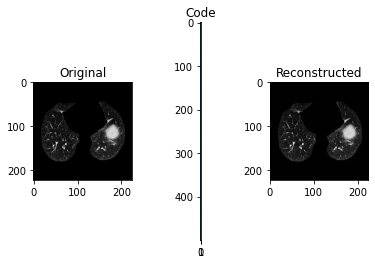

In [51]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(1):
    img =( x_test[i])
    visualize(img,encoder,decoder)

# PLOT OF IMAGES WHICH IS RECONSTRUCTED BY THE AUTOENCODER.  

In [52]:
predictions1=autoencoder.predict(x_train)

n = 1
plt.figure(figsize= (30,30))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(x_train[i+1][:,:,0])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions1[i+1][:,:,0])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

# BELOW ARE THE RECONSTRUCTED IMAGES AND ABOVE ARE ORIGINAL IMAGES

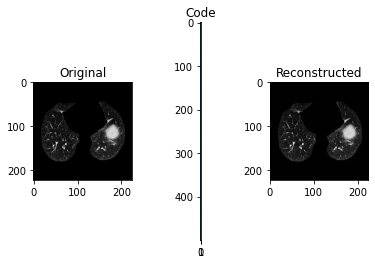

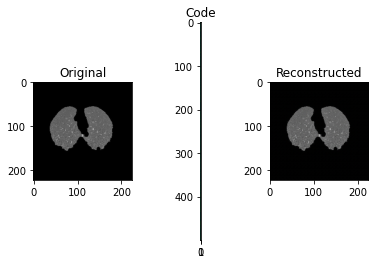

In [54]:
for i in range(2):
    img =( x_train[i])
    visualize(img,encoder,decoder)

In [55]:
datagen = ImageDataGenerator(
        rotation_range = 0,
        )

In [56]:
length=x_train

In [57]:
length=len(length)

In [58]:
length

2

In [59]:
from keras.preprocessing.image import array_to_img, img_to_array

In [60]:
for j in range(0,length):
    img =predictions1[j]
    x = img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size = 1,
                          save_to_dir ='D:/Sahana/New_Segment/autoencoders_output', 
                          save_prefix ='Autoencoder', save_format ='jpeg'):
        i += 1
        if i >=1 :
            break
    